# CP-TPP model on Cirzotinib
Analysis workflow for manuscript Johansson et al. "Integrating Cell Painting and Thermal Proteome Profiling for Improved Inference of Mechanism of Action"

In [2]:
import os
import pandas as pd 
import numpy as np
from matplotlib_venn import venn2

#Importing CP-TPP functions
import cp.cp as c
import tpp.tpp as tpp

#Keep when developing a function
from importlib import reload
reload(c)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'cp.cp_tpp_model' from '/share/data/analyses/camilla/cp_tpp/code/cp_tpp_model/cp/cp_tpp_model.py'>

You can get documentation for each function in the module cp_tpp_model by typing help(c.[name of function]), e.g. help(c.process_cp_to_median)

## Cell Painting data

### Importing and processing Cell Painting data for downstream analysis
The imported cell painting data has already been normalised and processed into Z-scores per image. The SPECs data was run over two experiments: SPECS 2k and SPECS 3k. These needs to be merged to generate the complete data set. 

After merging the two data sets, metadata and compound information is added to the file and features are summarised into median z-scores per well rather than per image, which reduces the size of the file. 

When we get access to the SPECS data from Phanindra, it has to be merged into the whole SPECS data at this step. 

In [3]:
#Importing cell painting data for SPECS project
#Importing SPECS 2k data
df2k =  pd.read_parquet('/share/data/analyses/maris/specs2k/ImageMeanFeaturesNormalized/specs2k_dfZscoresNormalizedPerPlateWithDMSOMedianMAD.parquet')
df2k['project'] = 'specs2k'

#Importing SPECS 3k data
df3k =  pd.read_parquet('/share/data/analyses/maris/specs3k_uncroped/ImageMeanFeaturesNormalized/specs3k_dfZscoresNormalizedPerPlateWithDMSOMedianMAD.parquet')
df3k['project'] = 'specs3k'

#Merge
dfAll = pd.concat([df2k, df3k], ignore_index = True, copy=True)
dfAll.dropna(inplace=True, axis=1)

# Import flags
QC =  pd.read_csv('/share/data/analyses/martin/024_specs_all/QC_SpecsAll_2K_3K_plots/Flags.csv', sep=';', index_col=[0])

# Merge flags with dfAll
df = dfAll.merge(QC, left_on = ['Metadata_Barcode', 'Metadata_Well',  'Metadata_Site'],
                 right_on = ['Metadata_Barcode', 'Metadata_Well',  'Metadata_Site'], how = 'left')

df = df[df['Total'] == 0 ]
df  = df[df['Count_nuclei'] >= 20] # optional: drop images that have less than e.g. 20 cells
df.drop(columns = 'Total', inplace=True)


# Process and summarise data to median z-scores
dfGroupedByPlate1 = c.process_cp_to_median(df, file_name='/share/data/analyses/camilla/cp_tpp/processed_data/median_processed_specs_all.parquet')

# Import annotations
annotations = pd.read_csv('/share/data/analyses/martin/024_specs_all/annotations.csv', sep=';', encoding='unicode_escape')

# Add compound annotations
# dfGroupedByPlate1 = dfGroupedByPlate1.merge(annotations, left_on='batch_id', right_on = 'Batch nr', how='left')


In [4]:
dfGroupedByPlate1.head()

Count_nuclei  AreaShape_Area_nuclei  AreaShape_BoundingBoxArea_nuclei  \
0         279.5               0.152467                          0.315815   
1         239.0               0.187259                          0.645446   
2         147.0              -0.438304                         -0.725424   
3         159.0               0.346499                          0.003773   
4         168.0               0.649833                          0.590539   

   AreaShape_BoundingBoxMaximum_X_nuclei  \
0                               0.551839   
1                              -0.329470   
2                               0.516265   
3                               0.914459   
4                              -0.607761   

   AreaShape_BoundingBoxMaximum_Y_nuclei  \
0                              -0.128661   
1                               0.033979   
2                              -0.692983   
3                               0.602903   
4                              -0.333192   

   AreaShape_BoundingBoxMinimum_X_nuclei  \
0                               0.538979   
1                              -0.317904   
2                               0.548414   
3                               0.915872   
4                              -0.611260   

   AreaShape_BoundingBoxMinimum_Y_nuclei  AreaShape_Center_X_nuclei  \
0                              -0.105070                   0.543602   
1                               0.036842                  -0.323929   
2                              -0.694865                   0.535324   
3                               0.659019                   0.919636   
4                              -0.335409                  -0.609274   

   AreaShape_Center_Y_nuclei  AreaShape_Compactness_nuclei  ...  cmpd_conc  \
0                  -0.116165                      0.104729  ...       10.0   
1                   0.036642                      0.990625  ...       10.0   
2                  -0.692454                      1.447833  ...       10.0   
3                   0.635690                     -0.556398  ...       10.0   
4                  -0.335213                      0.551538  ...       10.0   

   ImageQuality_MeanIntensity_HOECHST  ImageQuality_MeanIntensity_MITO  \
0                            0.035915                         0.096324   
1                            0.032455                         0.096063   
2                            0.050379                         0.128740   
3                            0.052737                         0.124666   
4                            0.059684                         0.122136   

   ImageQuality_MeanIntensity_PHAandWGA  ImageQuality_MeanIntensity_SYTO  \
0                              0.092770                         0.031289   
1                              0.084835                         0.033469   
2                              0.150275                         0.056225   
3                              0.160129                         0.067318   
4                              0.168836                         0.075757   

   ImageQuality_MedianIntensity_CONC   batch_id      cbkid  Metadata_Barcode  \
0                           0.043336  BJ1894240  CBK000155           P101369   
1                           0.022950  BJ1894240  CBK000155           P101368   
2                           0.027344  BJ1894337  CBK000156           P103602   
3                           0.027832  BJ1894337  CBK000156           P103601   
4                           0.048585  BJ1894320  CBK000161           P103614   

   project  
0  specs3k  
1  specs3k  
2  specs2k  
3  specs2k  
4  specs2k  

[5 rows x 1749 columns]

### Plot UMAP for all compounds of interest along with controls

In [2]:
#Read in processed data (if you have already run the previous step once)
dfGroupedByPlate1 =  pd.read_parquet('/share/data/analyses/camilla/cp_tpp/processed_data/median_processed_specs_all.parquet')

# Import annotations
annotations = pd.read_csv('/share/data/analyses/martin/024_specs_all/annotations.csv', sep=';', encoding='unicode_escape')

In [3]:
#Map compound codes to names
CompoundNames = {'CBK277930': 'Crizotinib'
                }

ControlNames = {'[berb]': '[berb]', '[sorb]': '[sorb]', '[etop]': '[etop]', '[fenb]': '[fenb]', 
                 '[ca-0]': '[ca-0]', '[flup]': '[flup]' , '[tetr]': '[tetr]'
               }

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


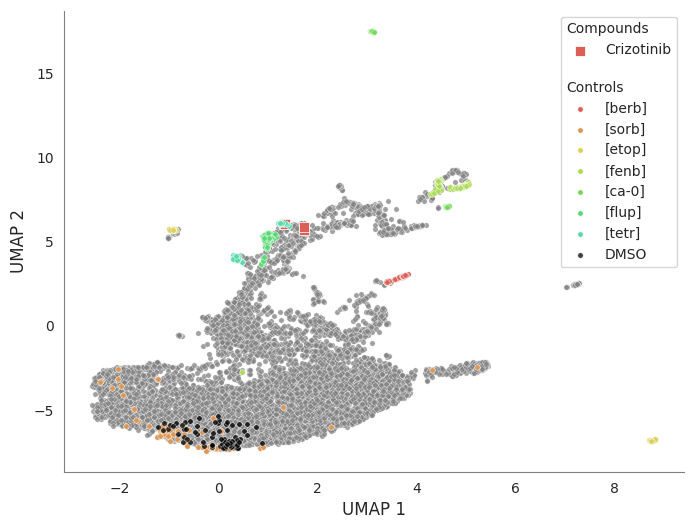

In [5]:
#Plot UMAP
c.umap_compounds(dfGroupedByPlate1, annotations, CompoundNames, ControlNames, file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/umap_Crizotinib.tiff')

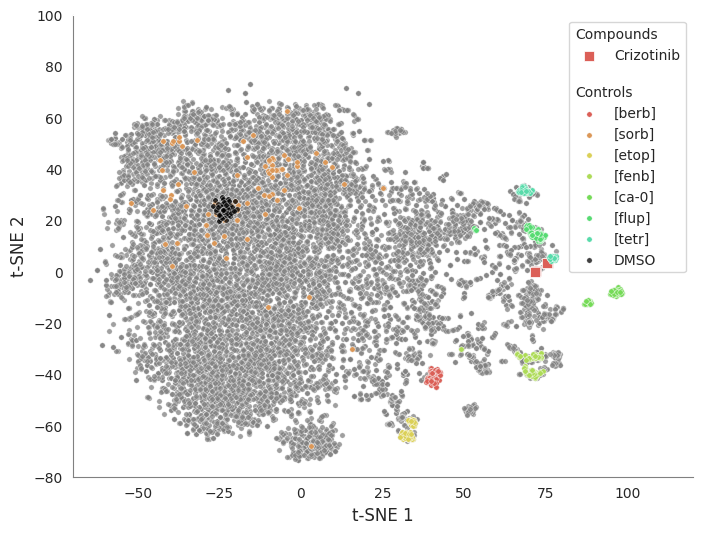

In [4]:
reload(c)
c.tsne_compounds(dfGroupedByPlate1, annotations, CompoundNames, ControlNames, file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/tsne_Crizotinib.svg')

### Cluster CP data using SC3s and plot smallest clusters for each compound

In [19]:
#Calculate consensus clustering
clusters_compounds = c.cluster_compound_sc3s(dfGroupedByPlate1, CompoundNames, batch_size = 2000, file_name='/share/data/analyses/camilla/cp_tpp/processed_data/pca_specs_all_withClusters.parquet')

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
INFO:root:multiplier_facility not set, using default value of 3...
INFO:root:number of facilities calculated as 540


Clustering with SC3s...


INFO:root:original binary matrix shape: (10941, 20000)
INFO:root:original binary matrix shape: (10941, 22000)
INFO:root:original binary matrix shape: (10941, 24000)
INFO:root:original binary matrix shape: (10941, 30000)
INFO:root:original binary matrix shape: (10941, 36000)


For compound I-BET151
Cluster sc3s_100 is 41 long.
Cluster sc3s_110 is 37 long.
Cluster sc3s_120 is 45 long.
Cluster sc3s_150 is 41 long.
Cluster sc3s_180 is 47 long.
Smallest cluster sc3s_110 with length 37
For compound (+)-JQ1
Cluster sc3s_100 is 41 long.
Cluster sc3s_110 is 37 long.
Cluster sc3s_120 is 45 long.
Cluster sc3s_150 is 41 long.
Cluster sc3s_180 is 47 long.
Smallest cluster sc3s_110 with length 37


/usr/local/lib/python3.10/dist-packages/pandas/io/parquet.py:190: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


In [5]:
#Read in consensus clusters if the cell above has already been run
reload(c)

principalDf_conc = pd.read_parquet('/share/data/analyses/camilla/cp_tpp/processed_data/pca_specs_all_withClusters_2000runs1.parquet')
n_clusters = [100, 110, 120, 150, 180]

#Reset index
CompoundNames2 = {'I-BET151': 'CBK278083', '(+)-JQ1': 'CBK278065'
                }

principalDf_conc['cbkid'] = principalDf_conc['cbkid'].replace(CompoundNames2)
principalDf_conc.sort_values(by = ['cbkid'], inplace = True)
principalDf_conc.reset_index(inplace=True, drop=True)
principalDf_conc['cbkid'] = principalDf_conc['cbkid'].replace(CompoundNames)

#Find cluster for each compound
clusters_compounds = {i:[] for i in CompoundNames.values()}
for i in CompoundNames.values():
    clusters_compounds[i] = c.find_cluster(principalDf_conc, n_clusters, i)

For compound Crizotinib
Cluster sc3s_100 is 42 long.
Cluster sc3s_110 is 48 long.
Cluster sc3s_120 is 41 long.
Cluster sc3s_150 is 39 long.
Cluster sc3s_180 is 40 long.
Smallest cluster sc3s_150 with length 39


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


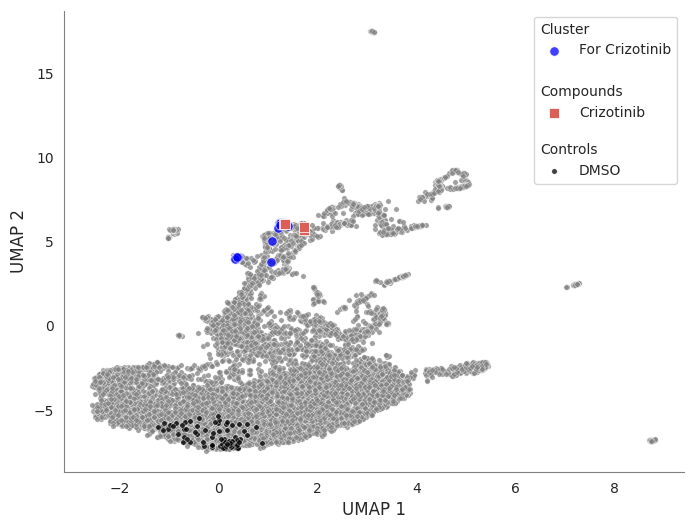

In [7]:
#Plot UMAP for identified clusters
c.umap_compounds(dfGroupedByPlate1, annotations, CompoundNames, ControlNames=None, Cluster=clusters_compounds, file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/umap_withClusters_Crizotinib.tiff')

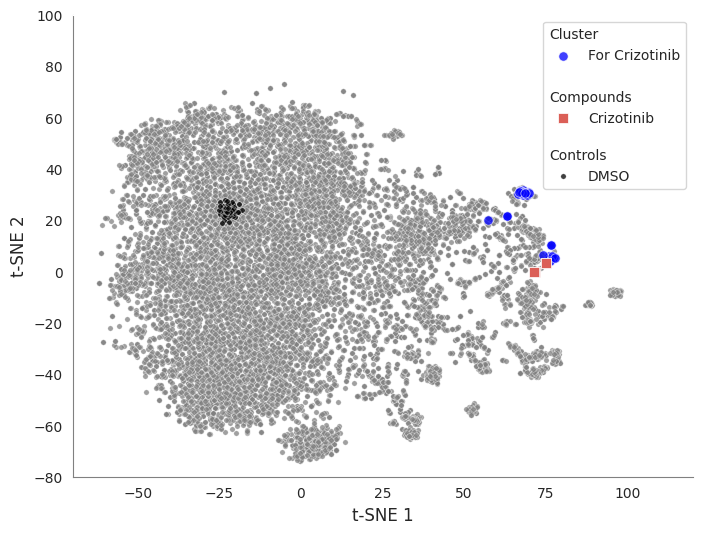

In [8]:
#Plot t-SNE for identified clusters
c.tsne_compounds(dfGroupedByPlate1, annotations, CompoundNames, ControlNames=None, Cluster=clusters_compounds, file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/tsne_withClusters_Crizotinib_2000rep.svg')

### Radar charts and feature similarity maps for compounds

In [9]:
#Read in processed data (if you have already run the previous step once)
dfGroupedByPlate1 =  pd.read_parquet('/share/data/analyses/camilla/cp_tpp/processed_data/median_processed_specs_all.parquet')

# Import annotations
annotations = pd.read_csv('/share/data/analyses/martin/024_specs_all/annotations.csv', sep=';', encoding='unicode_escape')

Crizotinib
Radar Chart saved as:
/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/radar_chart_Crizotinib.svg


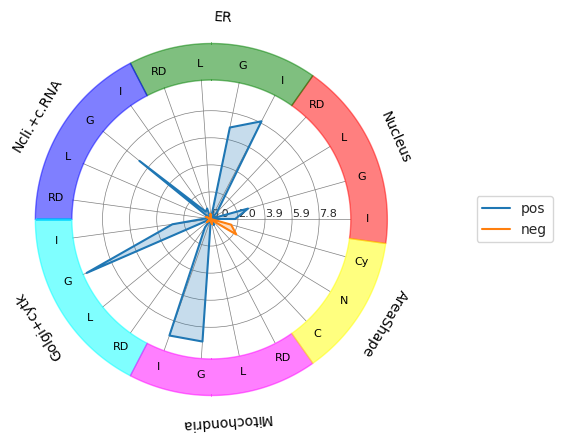

In [10]:
#Prepare data for plotting radar charts
reload(c)
dfRadar = c.processDataForRadar(dfGroupedByPlate1, CompoundNames)

#Plot radar charts
for compound in CompoundNames.values():
    print(compound)
    file_name = '/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/radar_chart_' + compound + '.svg'
    c.plotRadar(dfRadar, compound, file_name=file_name)

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


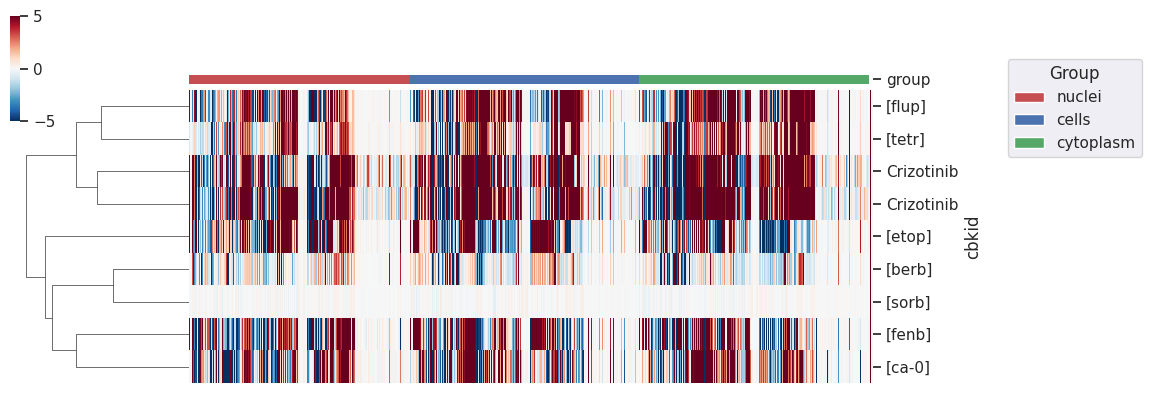

In [10]:
#Plot feature heatmap
c.plotFeatureHeatmap(dfGroupedByPlate1, CompoundNames, ControlNames, file_name=None)

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


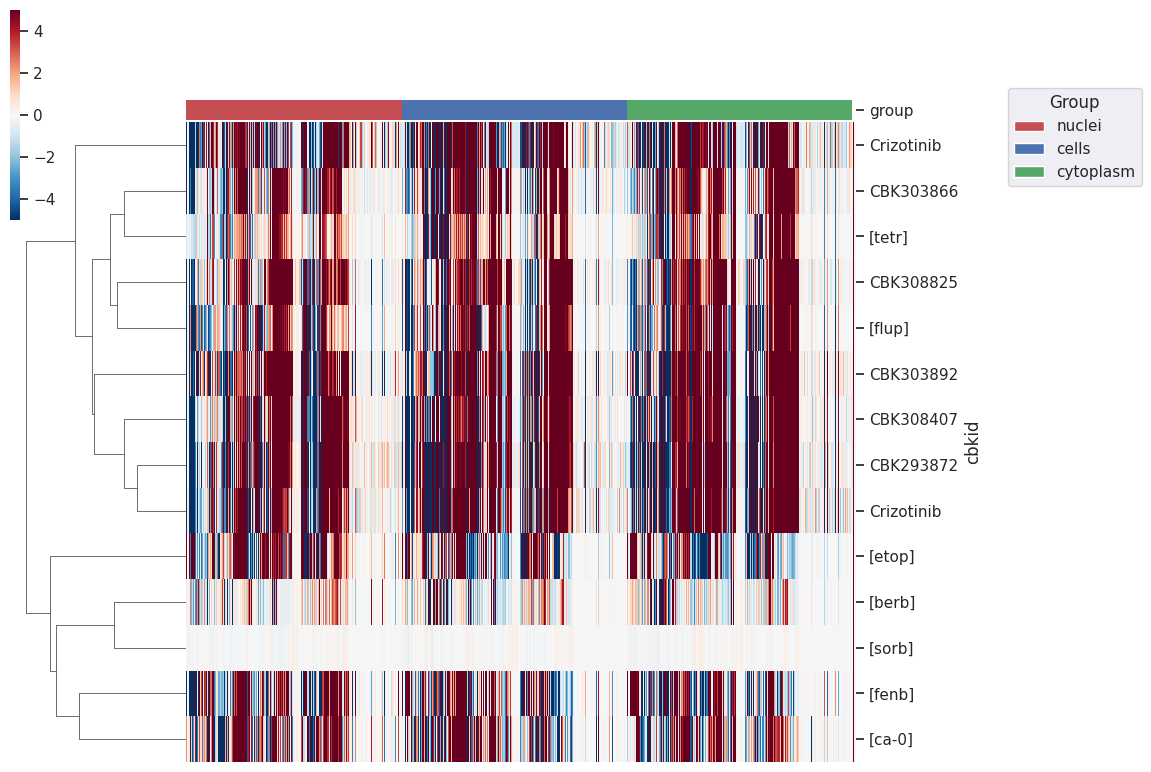

In [12]:
#Plot feature heatmap which includes compounds from SC3s clusters. 
c.plotFeatureHeatmap(dfGroupedByPlate1, CompoundNames, ControlNames, file_name=None, Cluster=clusters_compounds, height=7)

### Plot prevalence of compound targets in CP data
This was discussed on a meeting (2025-01-30). For the compounds we are interested in, how likely are they to map morphologically to other compounds targeting the same proteins? Since the approach in our model is built on the assumption that compounds will cluster closely to other compounds sharing similar targets, we need to also show to what extent this is true. 

In [17]:
reload(c)
#Extract targets for compounds of interest
targets_ibet151 = c.findTargetsForCompound(dfGroupedByPlate1, annotations, 'CBK278083')
targets_jq1 = c.findTargetsForCompound(dfGroupedByPlate1, annotations, 'CBK278065')
targets_jq1_ibet151 = targets_jq1 + targets_ibet151


In [29]:
#For all compounds in CP data, create a list of indices where compounds target any of these proteins. 
reload(c)
cluster_targets_jq1_ibet151 = c.findClusterForCompoundTargets(dfGroupedByPlate1, annotations, targets_jq1_ibet151)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


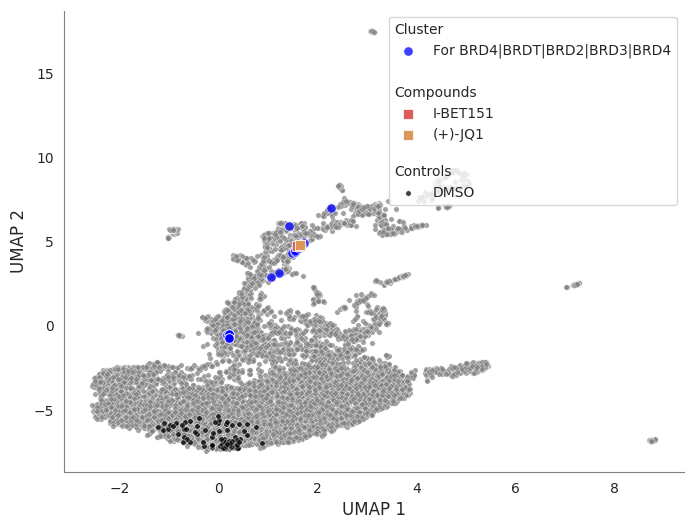

In [34]:
#Plot clusters in UMAP.
cluster_targets_jq1_ibet151_dict = {"|".join(targets_jq1_ibet151):cluster_targets_jq1_ibet151}

c.umap_compounds(dfGroupedByPlate1, 
                 annotations, 
                 CompoundNames, 
                 ControlNames=None, 
                 Cluster=cluster_targets_jq1_ibet151_dict, 
                 file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/umap_compoundsWithSharedTargets_IBET151_JQ1.tiff'
                )

**Repeat for Roscovitine**

In [35]:
reload(c)
#Extract targets for compounds of interest
targets_rosc = c.findTargetsForCompound(dfGroupedByPlate1, annotations, 'CBK278001')


In [36]:
#For all compounds in CP data, create a list of indices where compounds target any of these proteins. 
reload(c)
cluster_targets_rosc = c.findClusterForCompoundTargets(dfGroupedByPlate1, annotations, targets_rosc)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


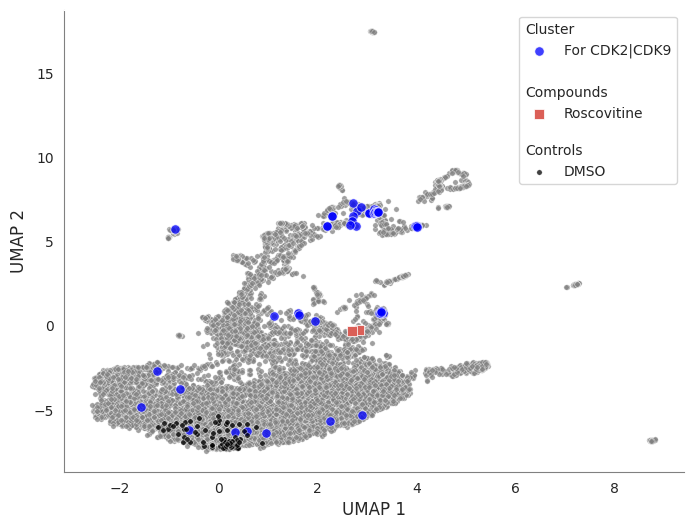

In [38]:
#Plot clusters in UMAP.
CompoundNames_rosc = {'CBK278001': 'Roscovitine'
                }

cluster_targets_rosc_dict = {"|".join(targets_rosc):cluster_targets_rosc}

c.umap_compounds(dfGroupedByPlate1, 
                 annotations, 
                 CompoundNames_rosc, 
                 ControlNames=None, 
                 Cluster=cluster_targets_rosc_dict, 
                 file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/umap_compoundsWithSharedTargets_Roscovitine.tiff'
                )

**Repeat for Vemurafenib**

In [65]:
reload(c)
#Extract targets for compounds of interest
targets_vem = c.findTargetsForCompound(dfGroupedByPlate1, annotations, 'CBK277976')


In [66]:
#For all compounds in CP data, create a list of indices where compounds target any of these proteins. 
reload(c)
cluster_targets_vem = c.findClusterForCompoundTargets(dfGroupedByPlate1, annotations, targets_vem)


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


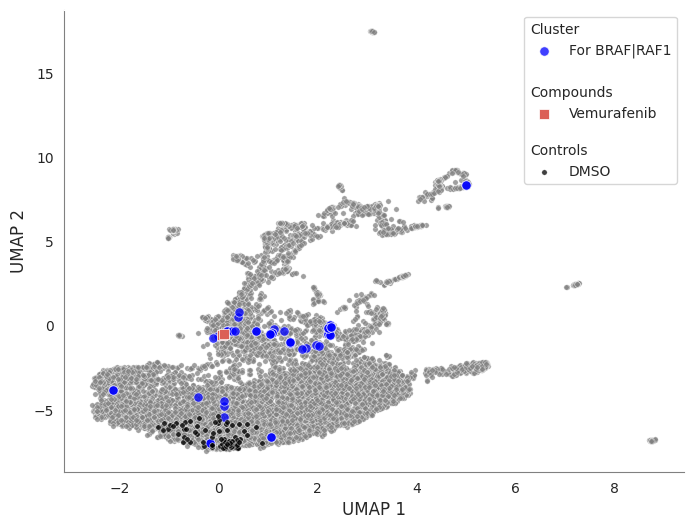

In [67]:
#Plot clusters in UMAP.
CompoundNames_vem = {'CBK277976': 'Vemurafenib'
                }

cluster_targets_vem_dict = {"|".join(targets_vem):cluster_targets_vem}

c.umap_compounds(dfGroupedByPlate1, 
                 annotations, 
                 CompoundNames_vem, 
                 ControlNames=None, 
                 Cluster=cluster_targets_vem_dict, 
                 file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/umap_compoundsWithSharedTargets_Vemurafenib.tiff'
                )

**Repeat for Crizotinib**

In [11]:
reload(c)
#Extract targets for compounds of interest
targets_cri = c.findTargetsForCompound(dfGroupedByPlate1, annotations, 'CBK277930')

#For all compounds in CP data, create a list of indices where compounds target any of these proteins. 
cluster_targets_cri = c.findClusterForCompoundTargets(dfGroupedByPlate1, annotations, targets_cri)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


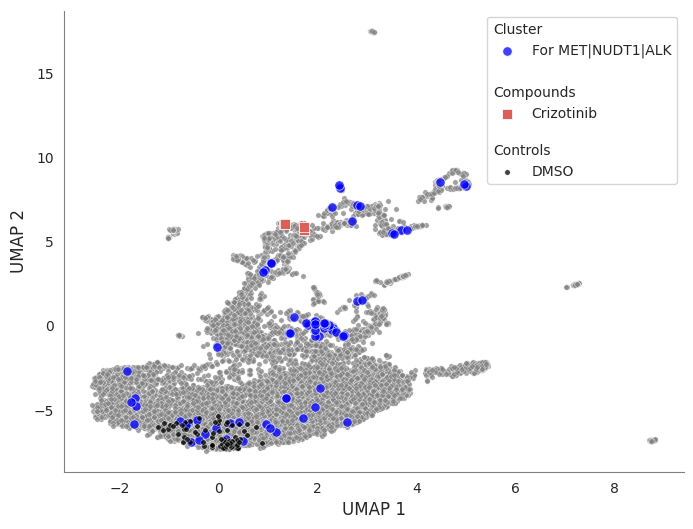

In [64]:
#Plot clusters in UMAP.
CompoundNames_cri = {'CBK277930': 'Crizotinib'
                }

cluster_targets_cri_dict = {"|".join(targets_cri):cluster_targets_cri}

c.umap_compounds(dfGroupedByPlate1, 
                 annotations, 
                 CompoundNames_cri, 
                 ControlNames=None, 
                 Cluster=cluster_targets_cri_dict, 
                 file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/umap_compoundsWithSharedTargets_Crizotinib.tiff'
                )

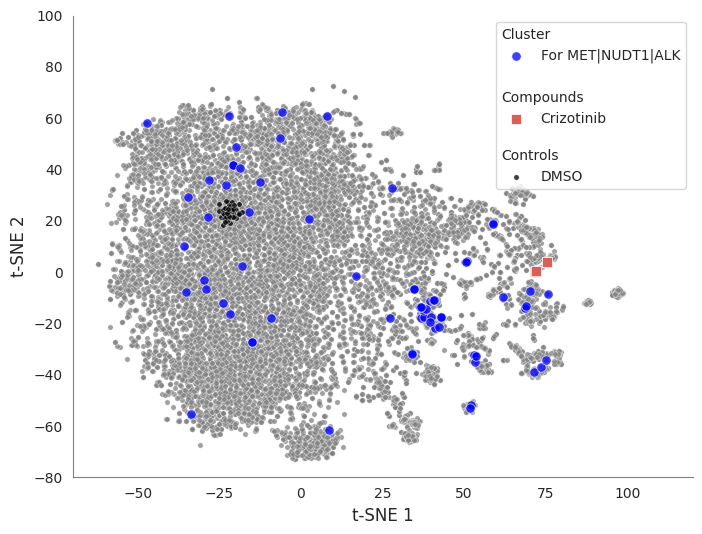

In [12]:
#Plot clusters in t-SNE.
CompoundNames_cri = {'CBK277930': 'Crizotinib'
                }

cluster_targets_cri_dict = {"|".join(targets_cri):cluster_targets_cri}

c.tsne_compounds(dfGroupedByPlate1, 
                 annotations, 
                 CompoundNames_cri, 
                 ControlNames=None, 
                 Cluster=cluster_targets_cri_dict, 
                 file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/tsne_compoundsWithSharedTargets_Crizotinib.svg'
                )

**Repeat for Panobinostat**

In [44]:
reload(c)
#Extract targets for compounds of interest
targets_pan = c.findTargetsForCompound(dfGroupedByPlate1, annotations, 'CBK277990')

#For all compounds in CP data, create a list of indices where compounds target any of these proteins. 
cluster_targets_pan = c.findClusterForCompoundTargets(dfGroupedByPlate1, annotations, targets_pan)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


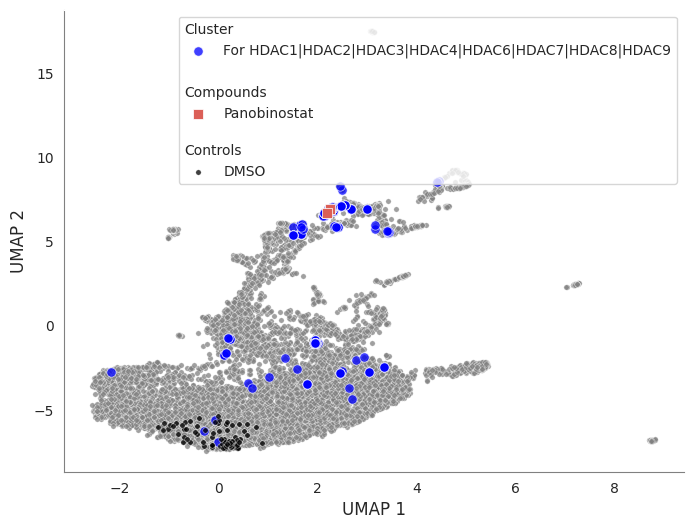

In [45]:
#Plot clusters in UMAP.
CompoundNames_pan = {'CBK277990': 'Panobinostat'
                }

cluster_targets_pan_dict = {"|".join(targets_pan):cluster_targets_pan}

c.umap_compounds(dfGroupedByPlate1, 
                 annotations, 
                 CompoundNames_pan, 
                 ControlNames=None, 
                 Cluster=cluster_targets_pan_dict, 
                 file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/umap_compoundsWithSharedTargets_Panobinostat.tiff'
                )

**Repeat for Elacridar**

In [ ]:
reload(c)
#Extract targets for compounds of interest
targets_elac = c.findTargetsForCompound(dfGroupedByPlate1, annotations, 'CBK291007')

#For all compounds in CP data, create a list of indices where compounds target any of these proteins. 
cluster_targets_elac = c.findClusterForCompoundTargets(dfGroupedByPlate1, annotations, targets_elac)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


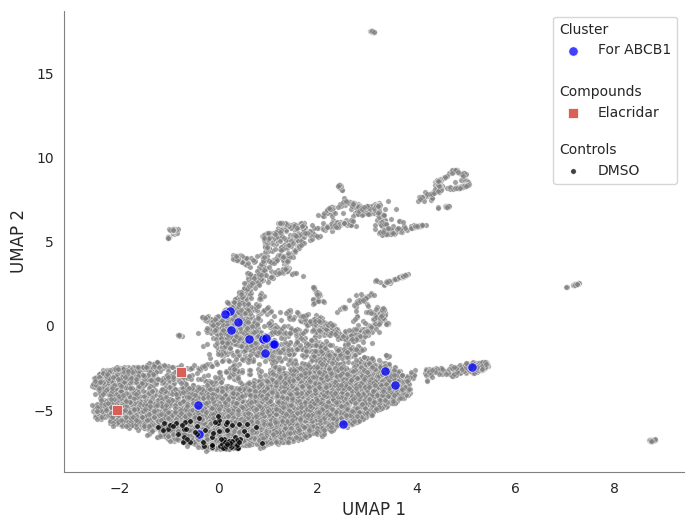

In [ ]:
#Plot clusters in UMAP.
CompoundNames_elac = {'CBK291007': 'Elacridar'
                }

cluster_targets_elac_dict = {"|".join(targets_elac):cluster_targets_elac}

c.umap_compounds(dfGroupedByPlate1, 
                 annotations, 
                 CompoundNames_elac, 
                 ControlNames=None, 
                 Cluster=cluster_targets_elac_dict, 
                 file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/umap_compoundsWithSharedTargets_Elacridar.tiff'
                )

## Thermal proteome profiling data

Thermal Proteome Profiling (TPP) should first be processed in R using the TPP library. https://www.bioconductor.org/packages/release/bioc/html/TPP.html 

Depending on the type of TPP experiment, different pre-processing functions are used, and this affects the appearance of the results table generated by the R function. Use the following functions from the TPP package depending on your data type: 

* TPP-TR: function "analyzeTPPTR". https://www.bioconductor.org/packages/release/bioc/vignettes/TPP/inst/doc/TPP_introduction_1D.pdf
* 2D-TPP: function "analyze2DTPP". https://www.bioconductor.org/packages/release/bioc/vignettes/TPP/inst/doc/TPP_introduction_2D.pdf

In both cases, data is assumed to contain TMT labels and you will need to create a "configTable" and "data" file with a few very specific columns for the functions to work. This is all very well described in the documentation linked above. 

The results generated with these functions include an excel file with all processed and normalised intensities and statistical test results. We will use these result files as input to this python model. 

### Extract significantly affected proteins from TPP data

In [13]:
#Import Vemurafenib data (special code, since different data format)
df_cri_rep1 = pd.read_excel('/share/data/analyses/camilla/cp_tpp/processed_data/savitsky_2014_itdr_vemurafenib_alectinib_crizotinib.xlsx', 
                       sheet_name=5, header=0)
df_cri_rep2 = pd.read_excel('/share/data/analyses/camilla/cp_tpp/processed_data/savitsky_2014_itdr_vemurafenib_alectinib_crizotinib.xlsx', 
                       sheet_name=6, header=0)

df_cri_rep1 = df_cri_rep1.loc[df_cri_rep1['Passed criteria for ITDR pEC50'] == 'YES',:]
df_cri_rep2 = df_cri_rep2.loc[df_cri_rep2['Passed criteria for ITDR pEC50'] == 'YES',:]

proteins_all_cri = list(set(list(df_cri_rep1['Protein NAME']) + list(df_cri_rep2['Protein NAME'])))



In [14]:
print('Number of proteins identified in Crizotinib treated whole cells: '+str(len(proteins_all_cri)))

Number of proteins identified in Crizotinib treated whole cells: 58


In [17]:
from unipressed import IdMappingClient
import time

#Find stabilized and destabilized proteins and create latex file for manuscript
df_out = pd.DataFrame.from_dict({"Gene names": proteins_all_cri,
                                    "Uniprot ID": ["NA"]*len(proteins_all_cri),
                                    "Stabilized/Destabilized rep 1": ["NA"]*len(proteins_all_cri),
                                     "Stabilized/Destabilized rep 2": ["NA"]*len(proteins_all_cri)
                                    })

#Add info about stabilisation/destabilisation
for protein in df_cri_rep1['Protein NAME']:
    if str(df_cri_rep1.loc[df_cri_rep1['Protein NAME'] == protein,'HillSlope ITDR']).find('-') >= 0:
        df_out.loc[df_out['Gene names'] == protein, 'Stabilized/Destabilized rep 1'] = 'stabilized'
    else:
        df_out.loc[df_out['Gene names'] == protein, 'Stabilized/Destabilized rep 1'] = 'destabilized'

for protein in df_cri_rep2['Protein NAME']:
    if str(df_cri_rep2.loc[df_cri_rep2['Protein NAME'] == protein,'HillSlope ITDR']).find('-') >= 0:
        df_out.loc[df_out['Gene names'] == protein, 'Stabilized/Destabilized rep 2'] = 'stabilized'
    else:
        df_out.loc[df_out['Gene names'] == protein, 'Stabilized/Destabilized rep 2'] = 'destabilized'

#Add Uniprot IDs
request = IdMappingClient.submit(
    source="Gene_Name", dest="UniProtKB", ids=list(df_out["Gene names"]), taxon_id=9606
)
time.sleep(15)

for i in list(request.each_result()):
    gene = i['from']
    prot = i['to']
    df_out.loc[df_out["Gene names"] == gene,"Uniprot ID"] = prot

#Save to latex table
df_out = df_out.to_latex(buf='/share/data/analyses/camilla/cp_tpp/tables/signifProteins_TPP_Crizotinib_latexTable.txt', index=False)

In [18]:
#Import external subcellular location data from Human Protein Atlas
feature_df = pd.read_csv("/share/data/analyses/camilla/cp_tpp/raw_data/subcellular_location.tsv", sep="\t")

#Import external cell line expression data from Human Protein Atlas
exp_df = pd.read_csv("/share/data/analyses/camilla/cp_tpp/raw_data/rna_celline.tsv", sep="\t")
exp_df = exp_df[exp_df["Cell line"] == "U2OS"]

#Define location of external data files needed for plotting. 
external_data = {"subcellular": ["/share/data/analyses/camilla/cp_tpp/raw_data/subcellular_location.tsv"],
                 "cell line": ["/share/data/analyses/camilla/cp_tpp/raw_data/rna_celline.tsv"],
                 #"num temp curves": ["/share/data/analyses/camilla/cp_tpp/processed_data/Supplementary Dataset 2_2D-TPP.xlsx", 
                 #                    {"sheet_name":1, "header":1}],
                 #"direction": ["/share/data/analyses/camilla/cp_tpp/processed_data/Supplementary Dataset 2_2D-TPP.xlsx", 
                 #                    {"sheet_name":1, "header":1}],
                 #"other TPP data": ["/share/data/analyses/camilla/cp_tpp/processed_data/Supplementary Dataset 2_2D-TPP.xlsx", 
                 #                    {"sheet_name":2, "header":1}, {"cutoff": 2}]
                }

### Plot subcellular extression histogram

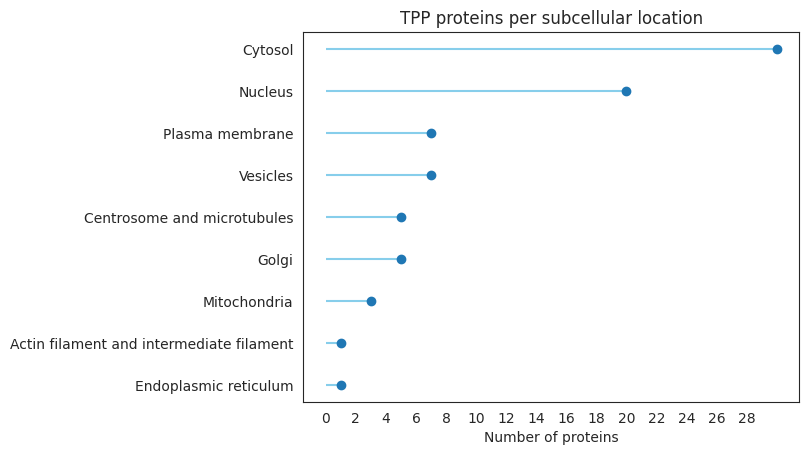

In [19]:
reload(c)
tpp.make_sl_histogram(proteins_all_cri, feature_df,
                     file_name="/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/histogram_subcellular_crizotinib_wc.svg")

### Plot networks

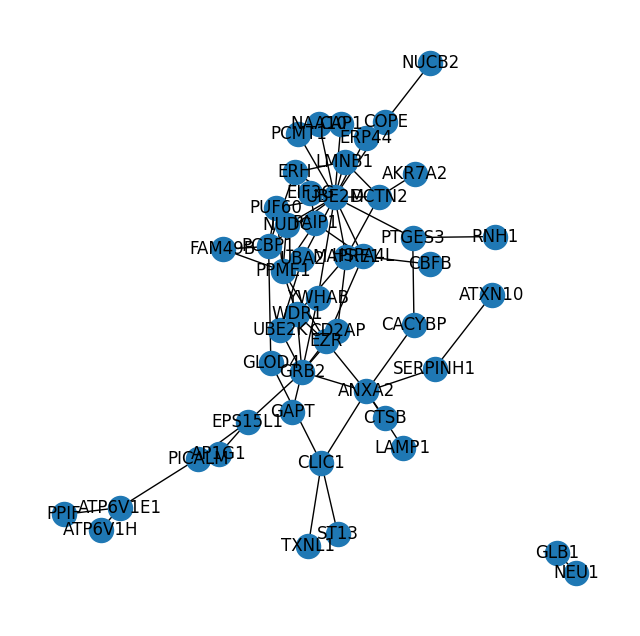

In [32]:
#Plot preliminary network
reload(tpp)
G_prel, interactions = tpp.retrievePreliminaryNetwork(proteins_all_cri, network_type="physical")

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  node_collection = ax.scatter(


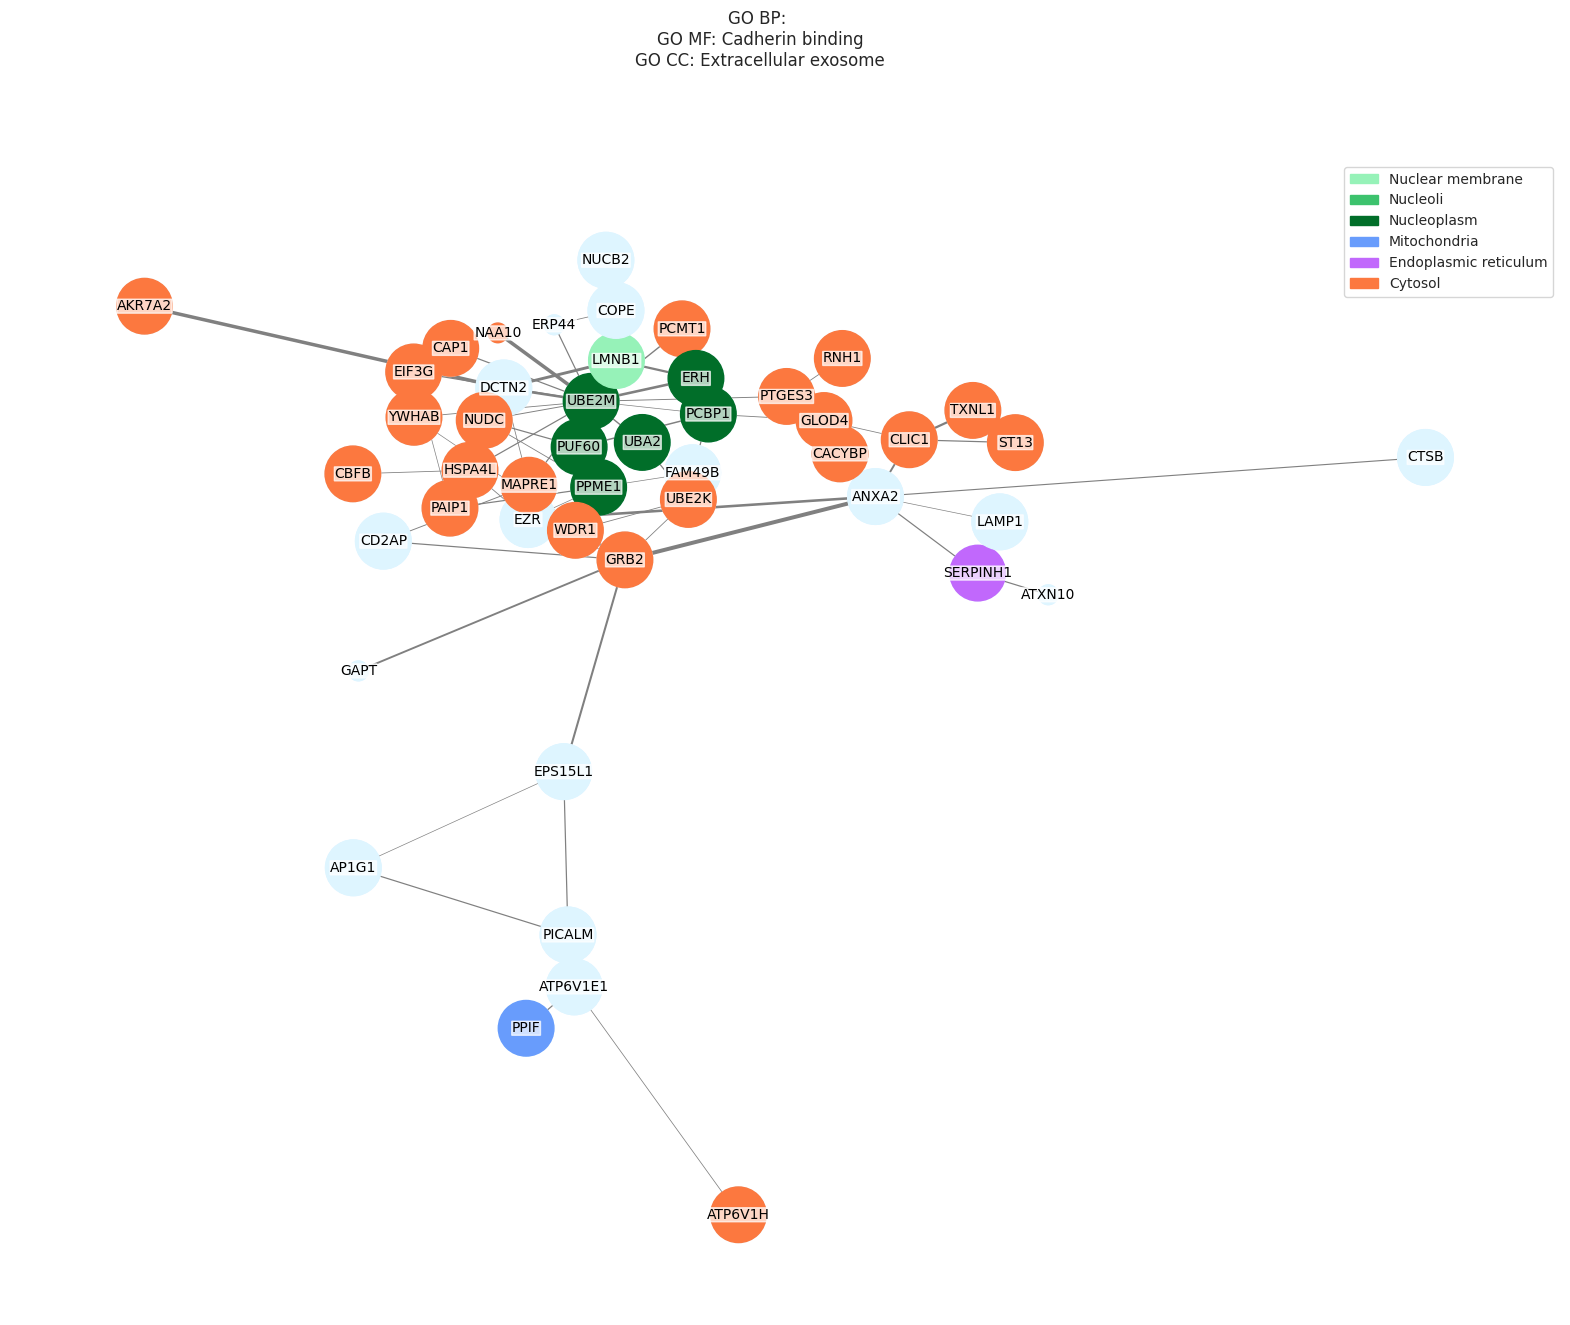

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  node_collection = ax.scatter(


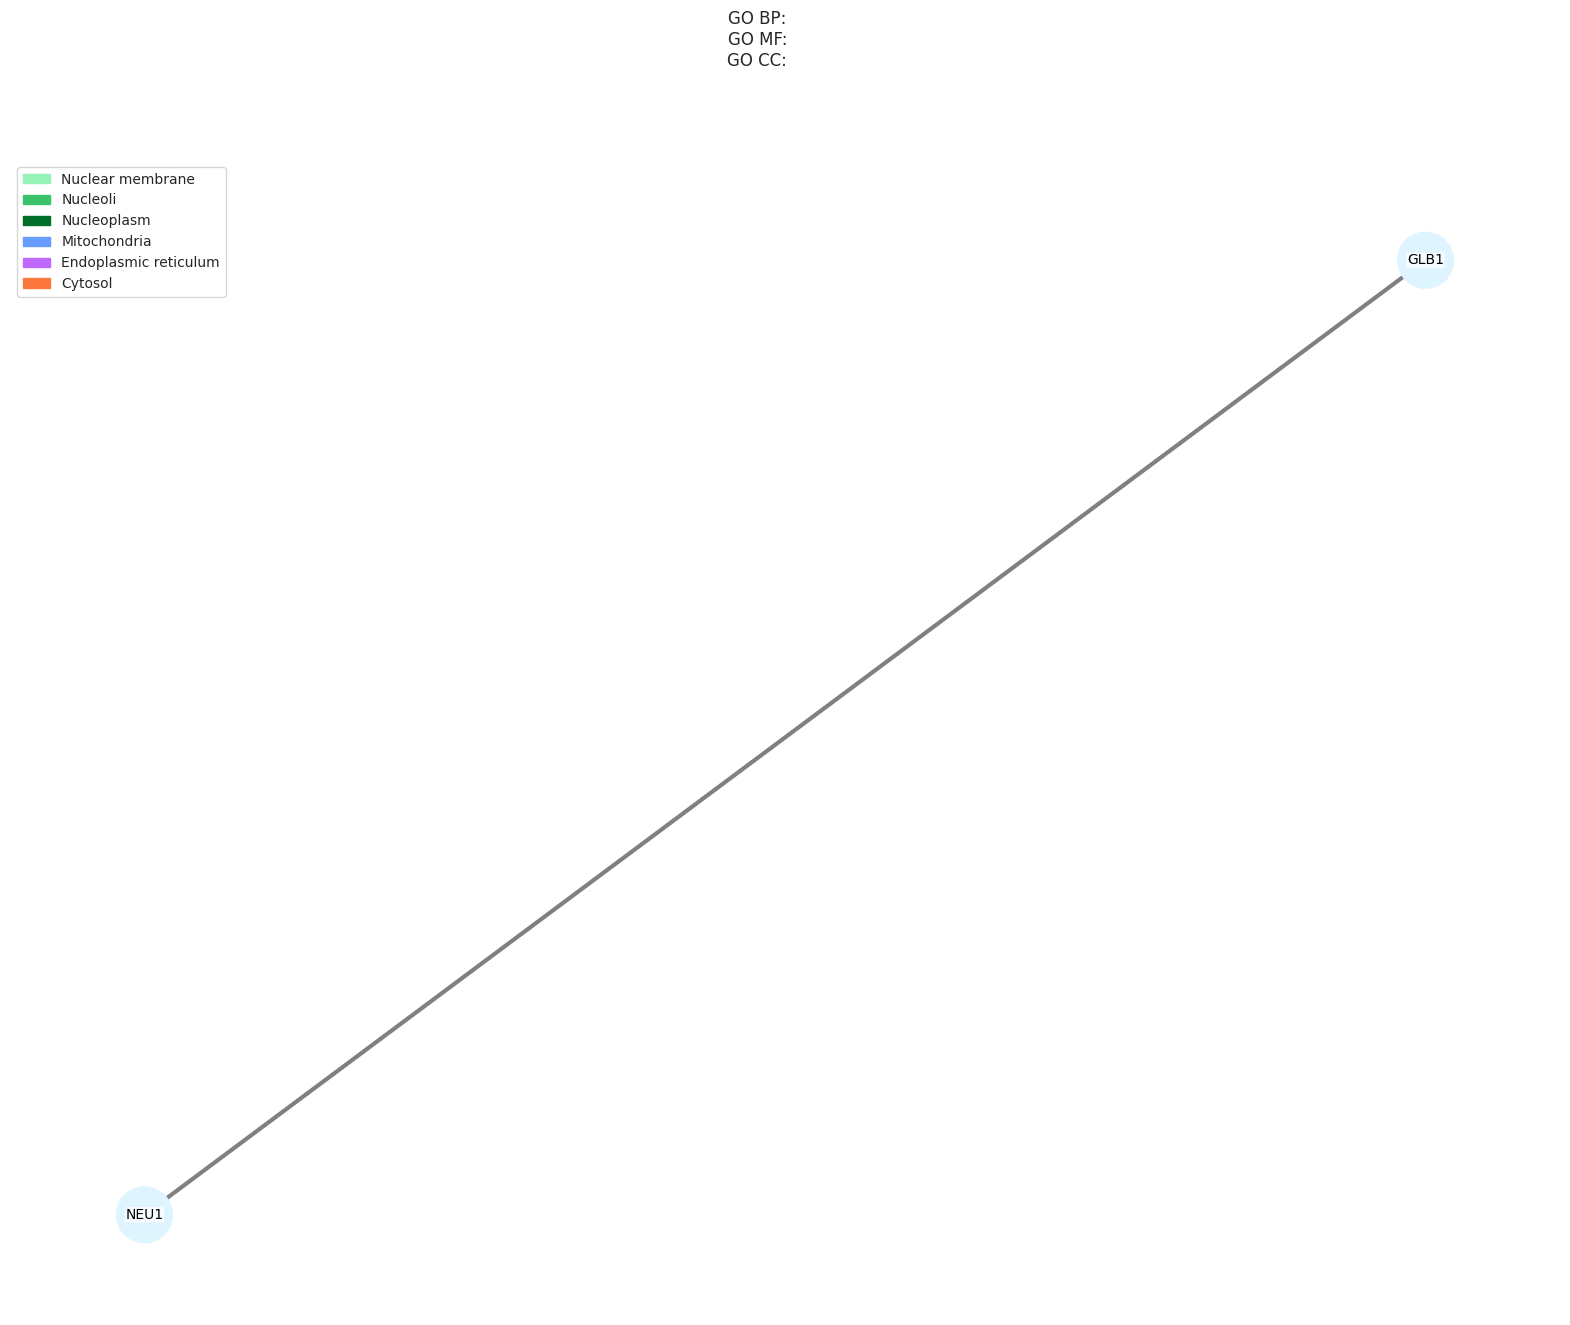

In [33]:
#Plot physical network 
#TODO: Additional legend with node size and edge thickness. 
#TODO: What else needs to be outputted?
#TODO: Make compatible with 1D TPP data. TPP-TR
reload(tpp)
between_c = tpp.plotPPINetwork(G_prel, 
                             interactions, 
                             community=2, #Number of separate (not connected) networks seen in preliminary network figure above.
                             protein_list=proteins_all_cri,
                             external_data=external_data,
                             file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/ppi_network_crizotinib_subcellular_we_physical.svg',
                             label_method="subcellular",
                             celline = "THP-1",
                             figure_size=(20,15)
                )

In [34]:
reload(c)
#Summarize betweenness centrality for network. 
between_df = tpp.findLargestBetweennessCentrality(between_c, proteins_all_cri, removeList=False, output_size=10)
print(between_df)

                0
UBE2M    0.482399
GRB2     0.342786
ANXA2    0.264396
EPS15L1  0.198068
PICALM   0.124638
YWHAB    0.119726
EZR      0.116779
CLIC1    0.107874
PCBP1    0.088905
HSPA4L   0.088808


In [35]:
#Import proteins from cluster
compound = ['Crizotinib']
cluster_compound_cri = clusters_compounds[compound[0]]

cluster_targets_cri = tpp.findClusterProteins(dfGroupedByPlate1, annotations, cluster_highlight=cluster_compound_cri, compound=compound, CompoundNames=CompoundNames)

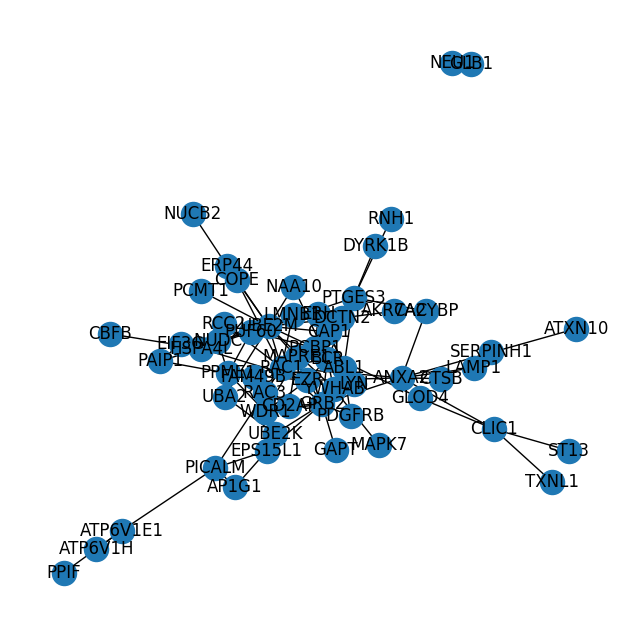

In [36]:
reload(c)
#Generate new network from string-db.
proteins_withCluster_cri = list(set(proteins_all_cri+cluster_targets_cri))

G_prel_clust, interactions_clust = tpp.retrievePreliminaryNetwork(proteins_withCluster_cri, network_type="physical") 

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  node_collection = ax.scatter(


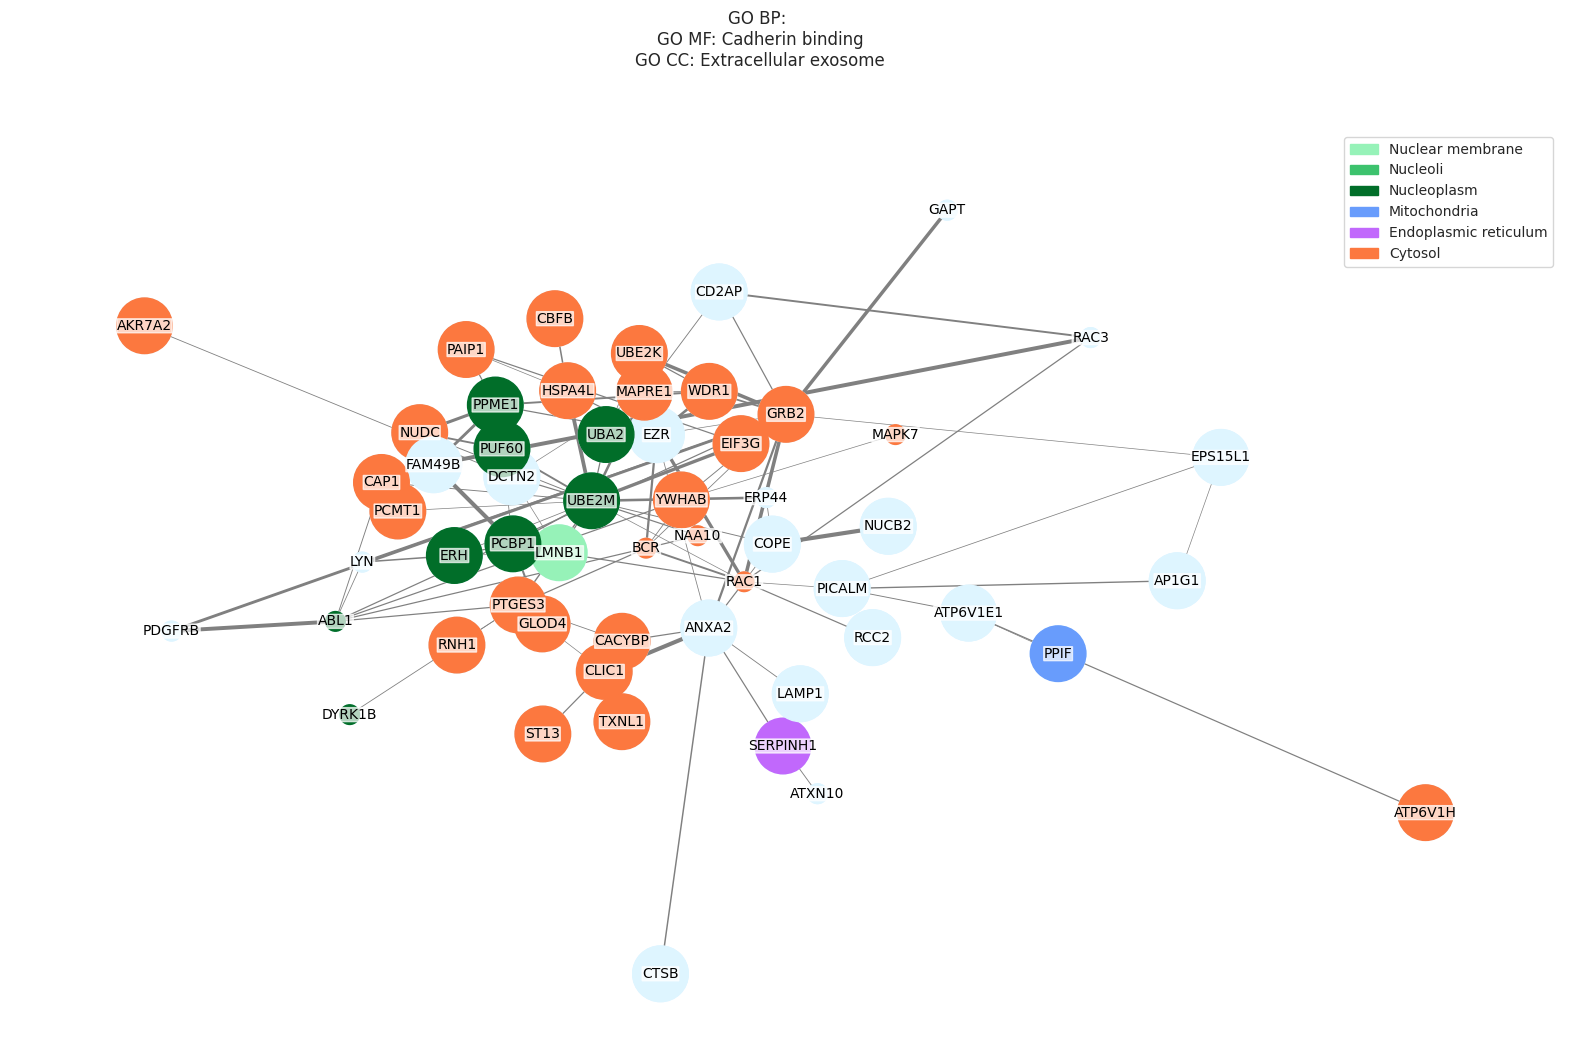

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  node_collection = ax.scatter(


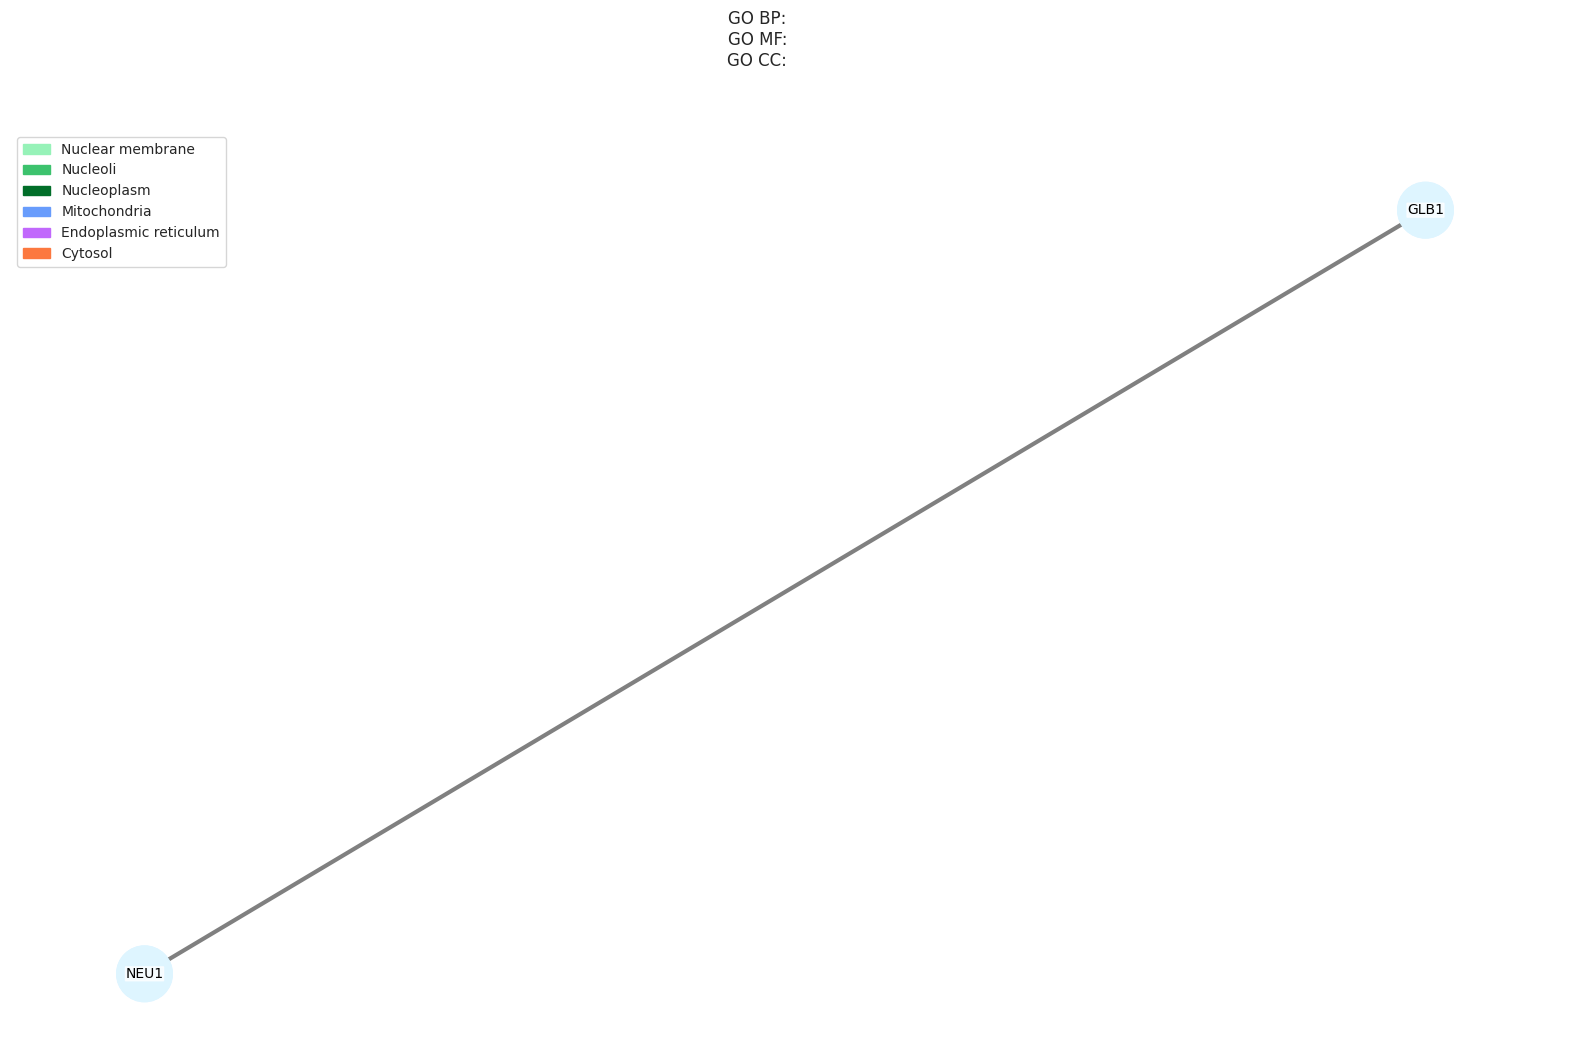

             0
RAC1  0.296054
BCR   0.039202
ABL1  0.028252
RAC3  0.013385
LYN   0.007377


In [37]:
#Plot new network from string-db.
reload(c)
between_c_clust = tpp.plotPPINetwork(G_prel_clust, 
                             interactions_clust, 
                             community=2, #Number of separate (not connected) networks seen in preliminary network figure above.
                             protein_list=proteins_all_cri,
                             external_data=external_data,
                             #file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/ppi_network_jq1_subcellular.svg',
                             label_method="subcellular",
                             #celline = "THP-1",
                             figure_size=(20,12)
                )
#Calculate betweenness centrality and keep only 5 best "additional" nodes. 
between_clust_df = tpp.findLargestBetweennessCentrality(between_c_clust, proteins_all_cri, removeList=True, output_size=5)
print(between_clust_df)

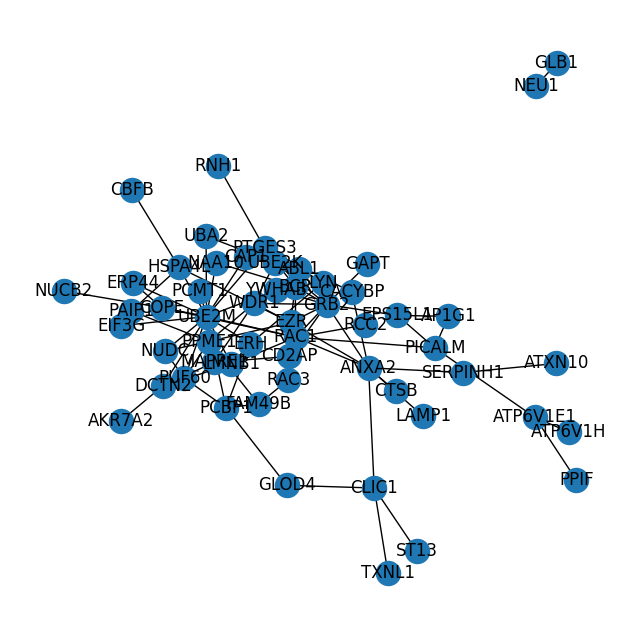

In [38]:
#Generate network with only best nodes
proteins_reducedCluster_cri = list(set(proteins_all_cri+list(between_clust_df.index)))

G_prel_clust, interactions_clust = tpp.retrievePreliminaryNetwork(proteins_reducedCluster_cri, network_type="physical") 

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  node_collection = ax.scatter(


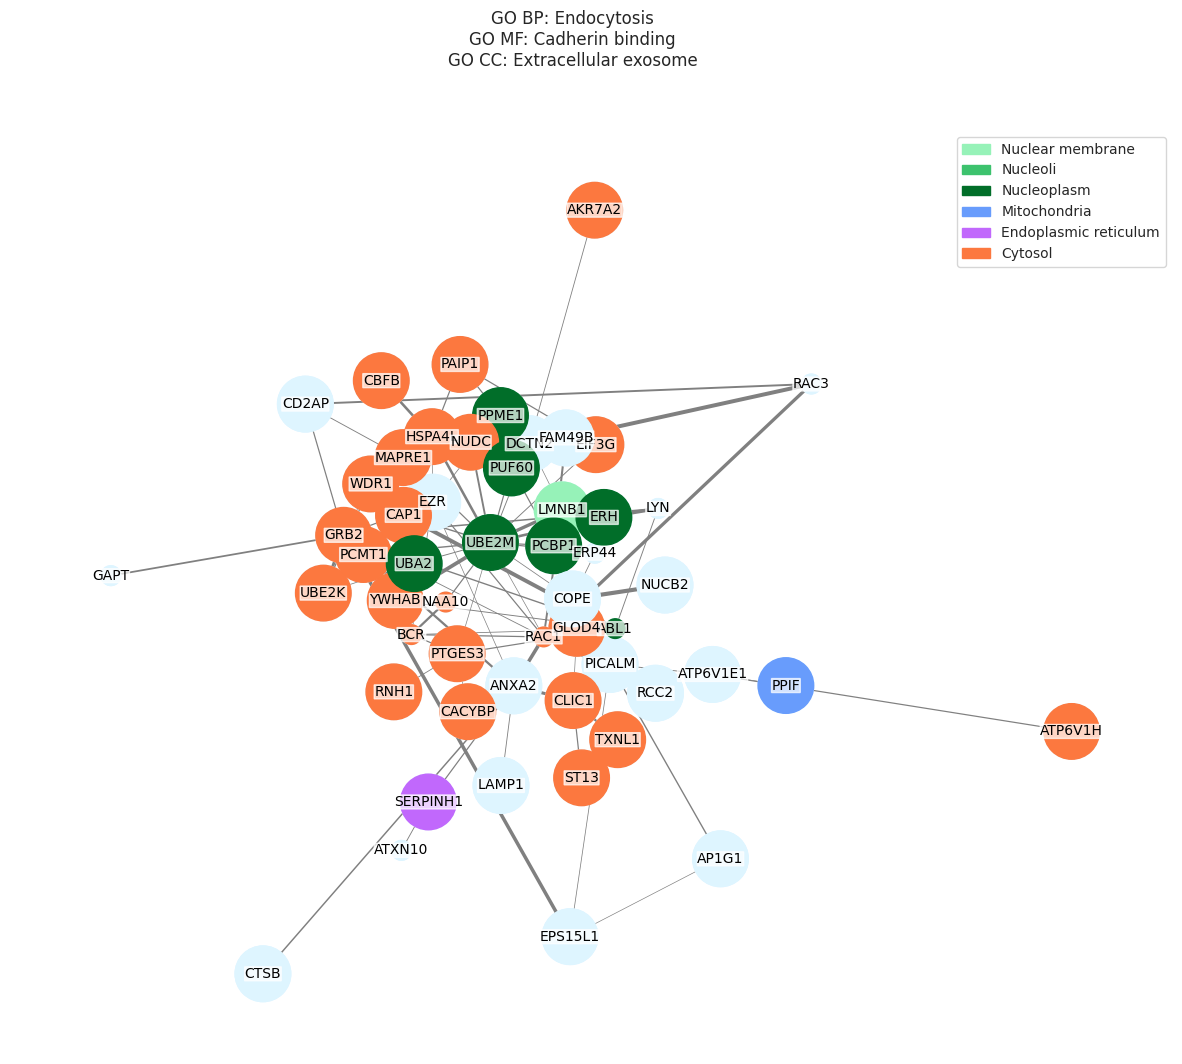

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  node_collection = ax.scatter(


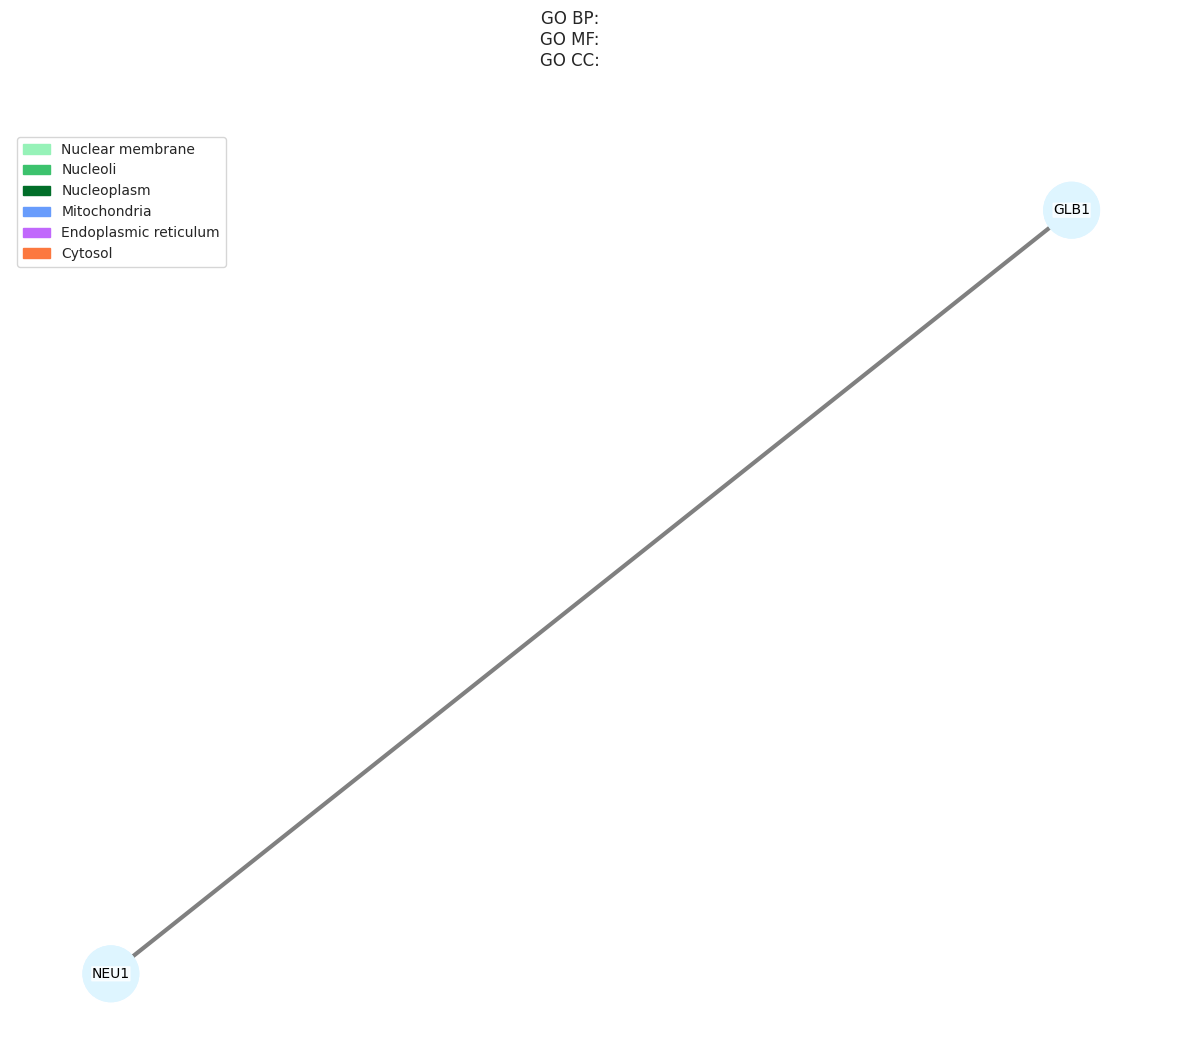

                 0
UBE2M     0.372502
RAC1      0.316575
ANXA2     0.253202
GRB2      0.183846
PICALM    0.136294
CLIC1     0.089765
EZR       0.080812
ATP6V1E1  0.076169
PTGES3    0.059598
HSPA4L    0.055607


In [39]:
#Plot final network.
reload(tpp)
between_c_clust = tpp.plotPPINetwork(G_prel_clust, 
                             interactions_clust, 
                             community=2, #Number of separate (not connected) networks seen in preliminary network figure above.
                             protein_list=proteins_all_cri,
                             external_data=external_data,
                             file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/ppi_network_crizotinib_subcellular_wc_physical_wCluster_2000rep.svg',
                             label_method="subcellular",
                             celline = "THP-1",
                             figure_size=(15,12)
                )
#Calculate betweenness centrality and keep only 5 best "additional" nodes. 
between_clust_df = tpp.findLargestBetweennessCentrality(between_c_clust, proteins_all_cri, removeList=False, output_size=10)
print(between_clust_df)

/share/data/analyses/camilla/cp_tpp/code/cp_tpp_model/tpp/tpp.py:921: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pTPM_dict[i] = float(cluster_count_df[cluster_count_df["Target"] == i]["Count"]) #This gives warning now.


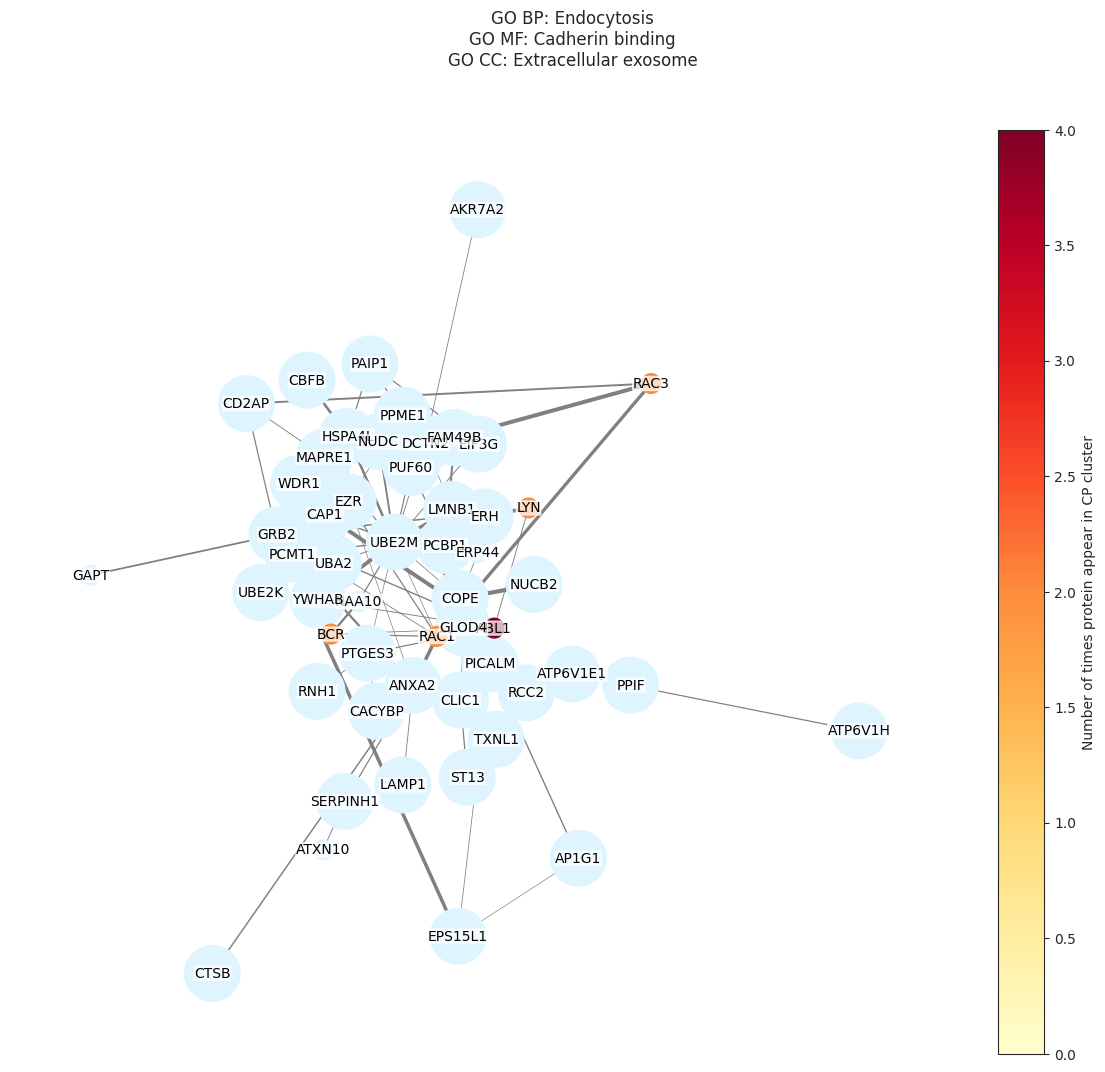

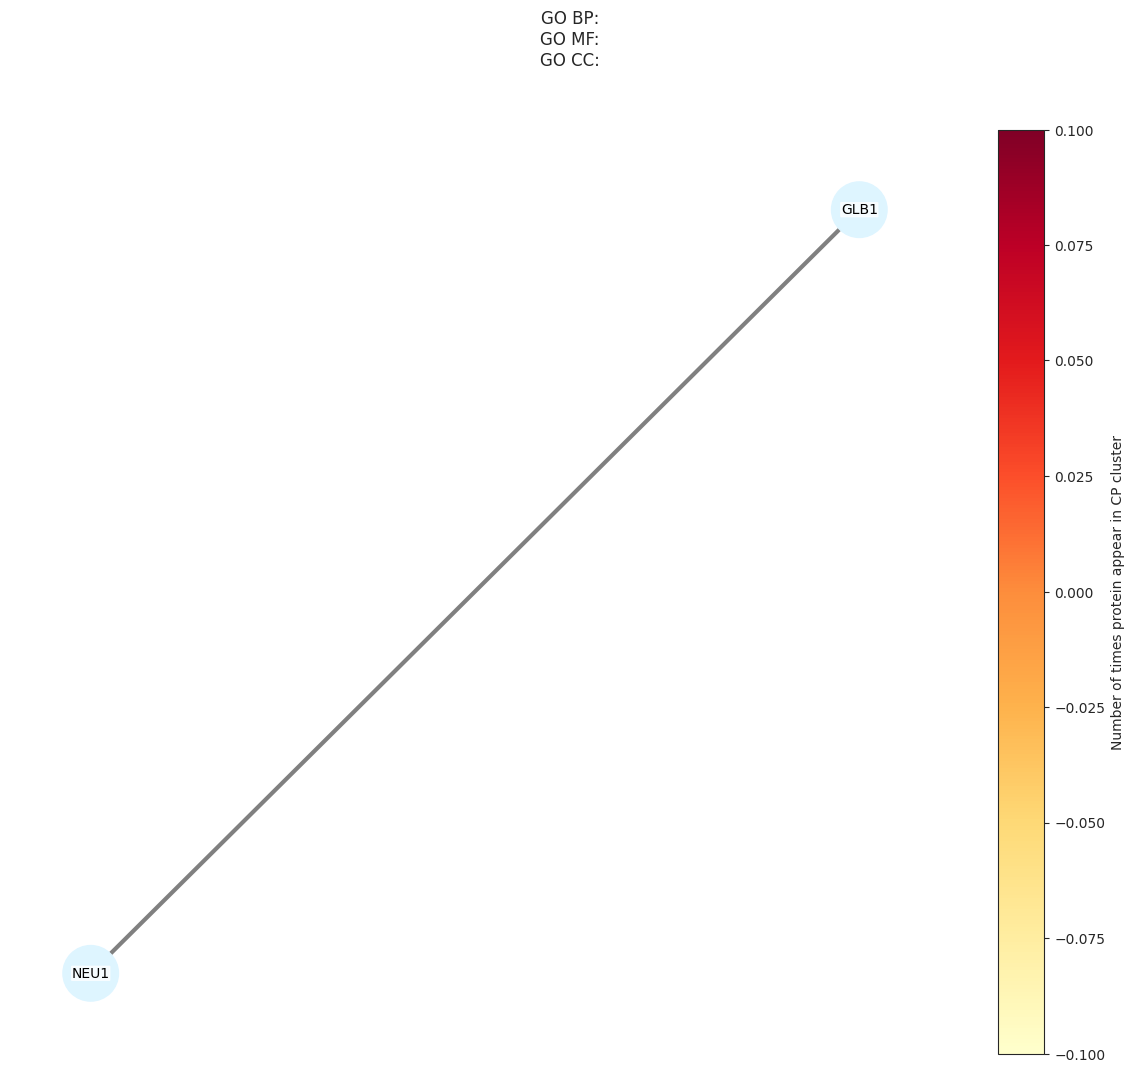

In [40]:
#Plot network colored by how many times a protein is present in cluster from cell painting data
reload(tpp)
cluster_protein_counts = tpp.countClusterProteins(dfGroupedByPlate1, annotations, cluster_highlight=cluster_compound_cri, compound=compound, CompoundNames=CompoundNames)

between_c_clust = tpp.plotPPINetwork(G_prel_clust, 
                             interactions_clust, 
                             community=2, #Number of separate (not connected) networks seen in preliminary network figure above.
                             protein_list=proteins_all_cri,
                             external_data=external_data,
                             file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/ppi_network_crizotinib_clusterCount_wc_physical_wCluster_2000rep.svg',
                             label_method="cluster count",
                             celline = "THP-1",
                             cluster_count_df = cluster_protein_counts,
                             figure_size=(15,12)
                )

### Communitites and GO/Reactome enrichment

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  node_collection = ax.scatter(


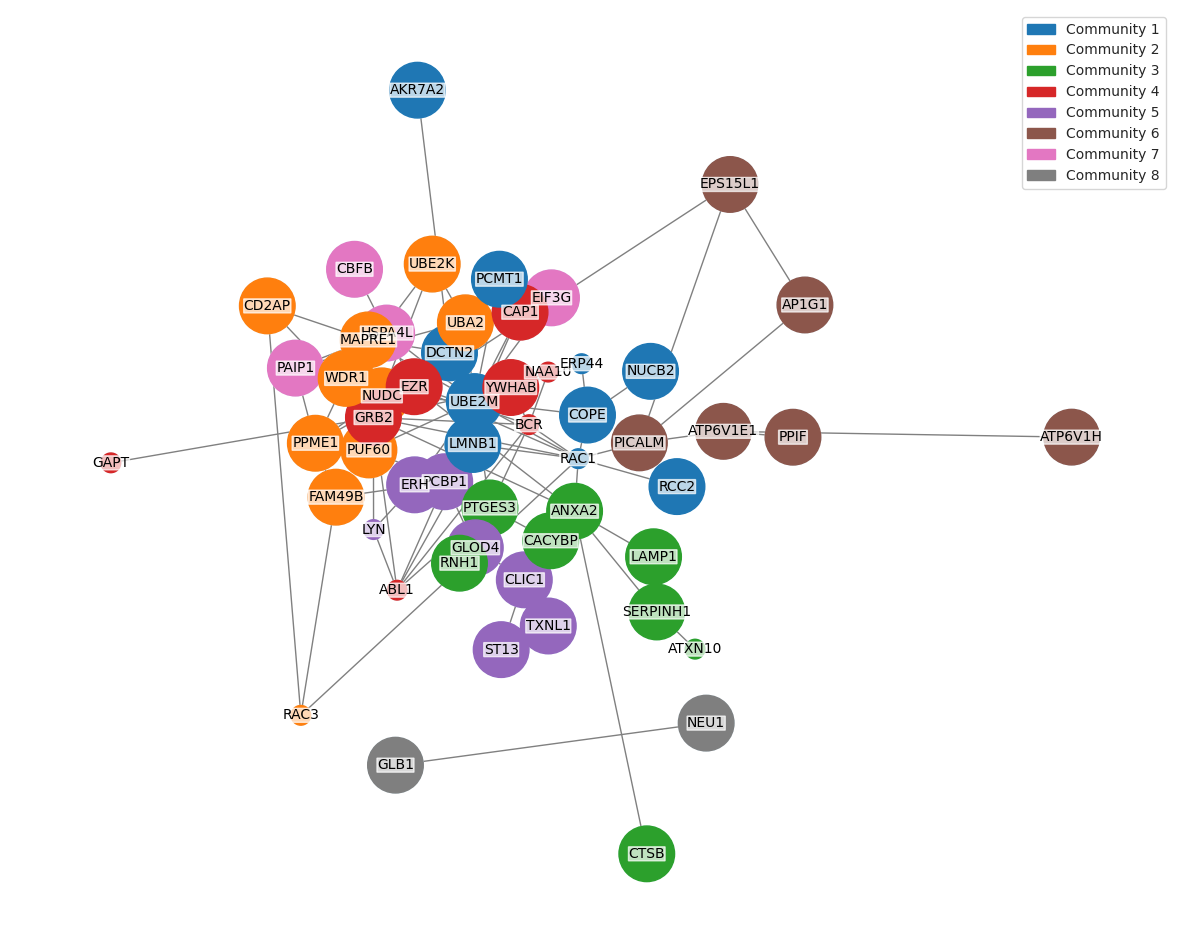

In [41]:
#Plot PPI network graph with communities as colors 
reload(tpp)
enrichment = tpp.plotPPINetworkCommunitites(G_prel_clust, 
                             interactions_clust, 
                             community=8, #Number of communities to subdivide graph into.
                             protein_list=proteins_all_cri,
                             method = 'greedy_modularity_communities', # Method for identifying communitites. 
                             file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/ppi_network_crizotinib_communities_wc_physical_wCluster_2000rep.svg',
                             figure_size=(15,12)
                )

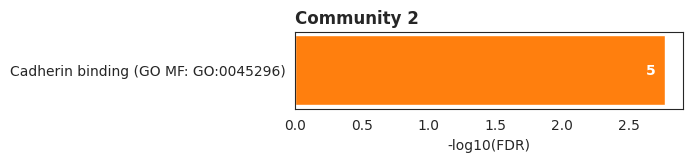

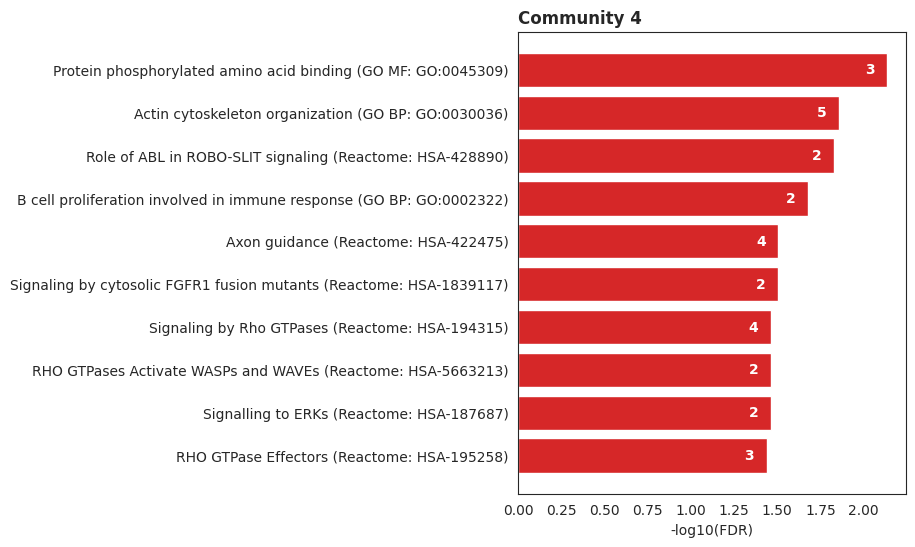

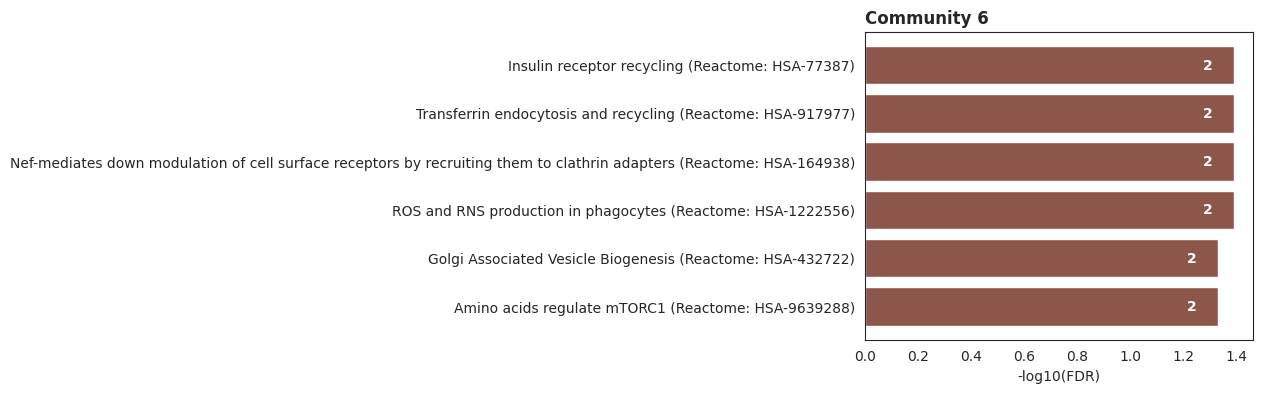

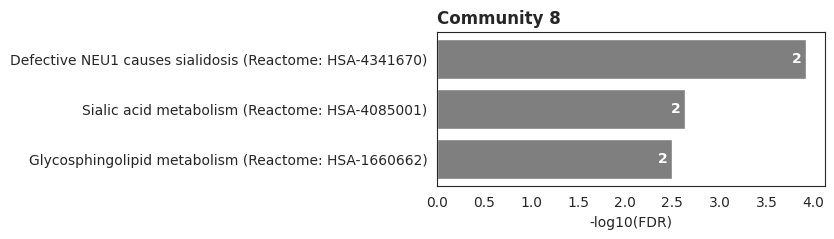

In [42]:
# Plots GO enrichment analysis for communitites. 
reload(tpp)
tpp.plotGOenrichmentCommunities(enrichment, 
                            file_name = "/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/enrichment_plots_crizotinib_communities_wc_physical_wCluster_2000rep.svg"
                           )

### Network for only CP cluster targets

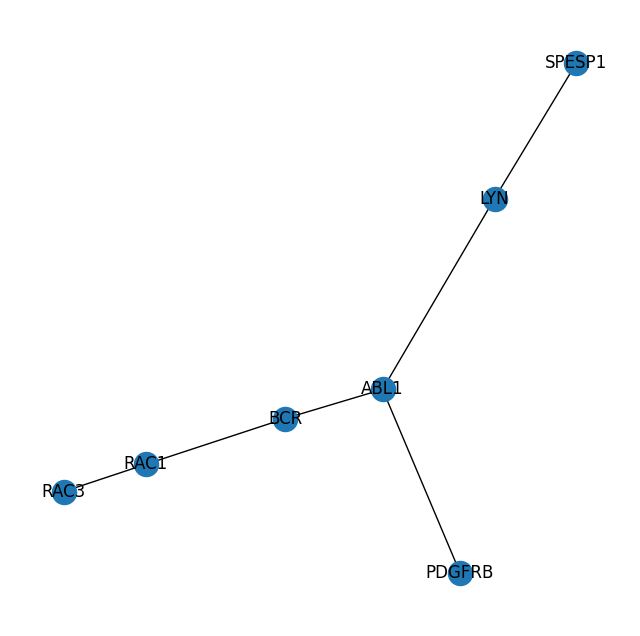

In [43]:
#Plot preliminary network
reload(c)
G_prel, interactions = tpp.retrievePreliminaryNetwork(cluster_targets_cri, network_type="physical")

/share/data/analyses/camilla/cp_tpp/code/cp_tpp_model/tpp/tpp.py:921: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pTPM_dict[i] = float(cluster_count_df[cluster_count_df["Target"] == i]["Count"]) #This gives warning now.


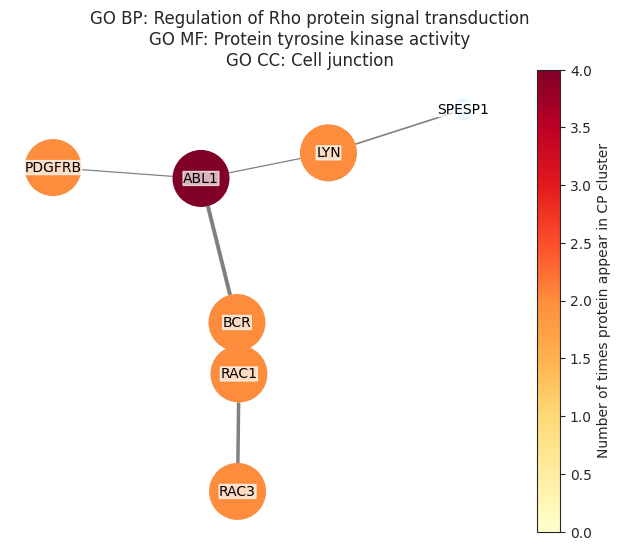

               0
ABL1    0.733333
BCR     0.533333
LYN     0.333333
RAC1    0.333333
SPESP1  0.000000
PDGFRB  0.000000
RAC3    0.000000


In [45]:
between_c_clust = tpp.plotPPINetwork(G_prel, 
                             interactions, 
                             community=1, #Number of separate (not connected) networks seen in preliminary network figure above.
                             protein_list=cluster_targets_cri,
                             external_data=external_data,
                             file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/ppi_network_crizotinib_clusterCount_physical_cpOnly_2000rep.svg',
                             label_method="cluster count",
                             celline = "THP-1",
                             cluster_count_df = cluster_protein_counts,
                             figure_size=(8,6)
                )

between_clust_df = tpp.findLargestBetweennessCentrality(between_c_clust, cluster_targets_cri, removeList=False, output_size=10, cluster_index=0)
print(between_clust_df)

In [29]:
compound

['Crizotinib']

### Extract MoA information from CP cluster
The cluster in cell painting data can also be used to propose MoA. Here we extract and cound those detected MoAs (without including the MoA annotations from target compounds) and plot as histograms. 

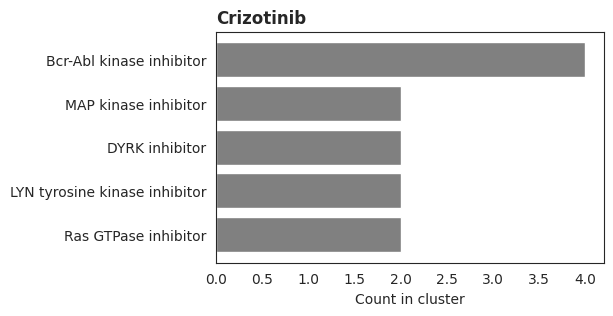

In [47]:
reload(tpp)
compound_list_cluster = tpp.plotClusterMOA(dfGroupedByPlate1, 
                   annotations, 
                   clusters_compounds['Crizotinib'], 
                   ['Crizotinib'], 
                   CompoundNames,
                   file_name = '/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/barchart_crizotinib_cluster_moa_2000rep.svg'
                  )

### Venn diagrams

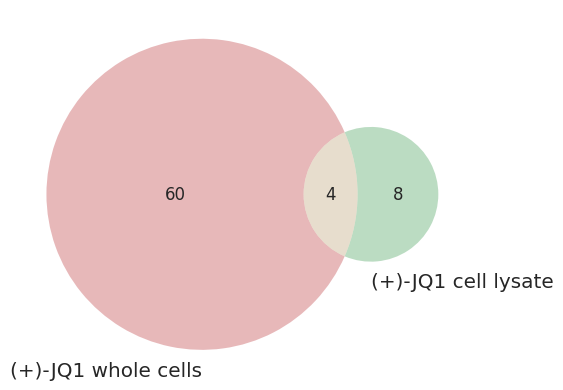

In [422]:
#Plot Venn Diagram for intercept between whole cells and cell lysat fore JQ1
set1 = set(proteins_all_jq1)
set2 = set(proteins_all_jq1_ce)

venn2((set1, set2), set_labels = ('(+)-JQ1 whole cells', '(+)-JQ1 cell lysate'))

plt.savefig("/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/venn_diagram_jq1_wc_vs_ce.svg")
plt.show()

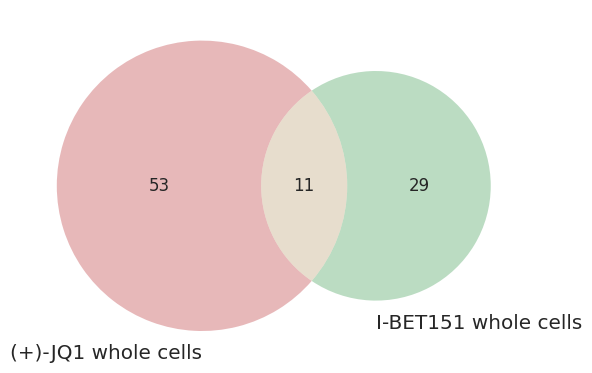

In [423]:
#Plot Venn Diagram for intercept between JQ1 and I-BET151 (whole cells)
set1 = set(proteins_all_jq1)
set2 = set(proteins_all_ibet151)

venn2((set1, set2), set_labels = ('(+)-JQ1 whole cells', 'I-BET151 whole cells'))

plt.savefig("/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/venn_diagram_jq1_vs_ibet151.svg")
plt.show()

### Identifying potentially missing hub nodes in network based on top 10 protein list. 
Retrieve all STRING interactions for top 10 protein list of the combined TPP-CP network. Count prevalence of interactions above a score

In [63]:
reload(tpp)
df_newHubs = tpp.findAdditionalHubProteins(list(between_c_clust[0].keys()), proteins_all_cri, network_type="physical")
#df_newHubs = tpp.findAdditionalHubProteins(list(between_clust_df.index), network_type="physical")

In [67]:
df_newHubs.loc[df_newHubs['interactor'] == 'MET',:]

interactor  count
1461        MET      1

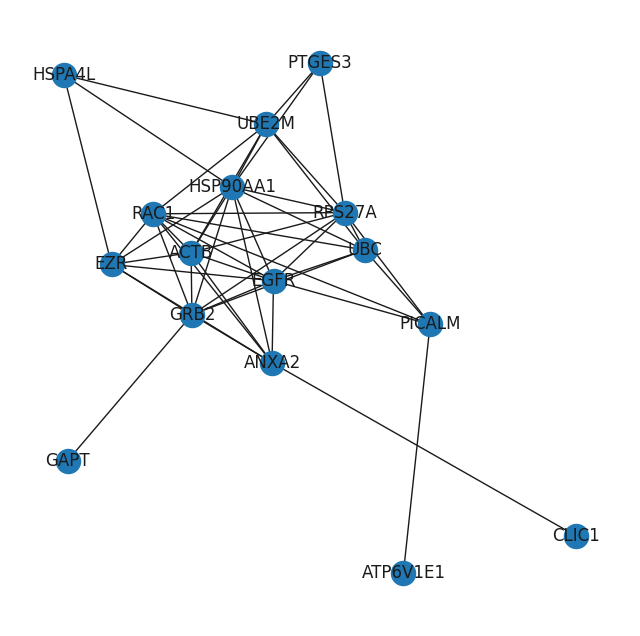

In [65]:
#New network with top 10 of these extra hubs added: 
proteins_hubs = list(df_newHubs.head(5)['interactor'])
proteins_withHubs_cri = list(set(proteins_hubs+list(between_clust_df.index)))

G_prel_hub, interactions_hub = tpp.retrievePreliminaryNetwork(proteins_withHubs_cri, network_type="physical") 

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  node_collection = ax.scatter(


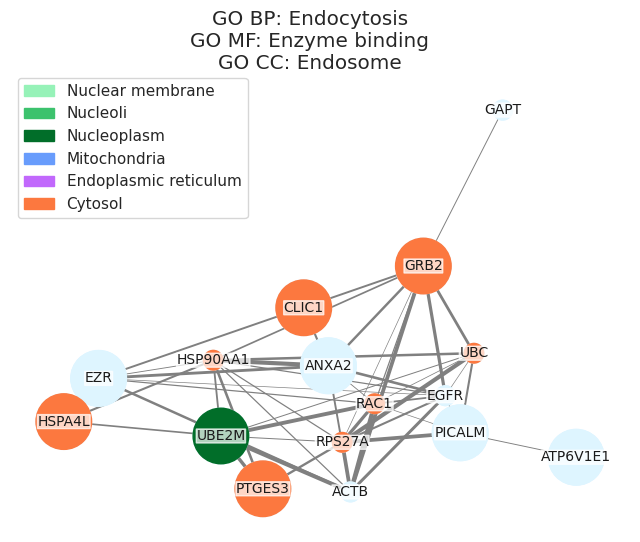

                 0
GRB2      0.148968
ANXA2     0.134524
PICALM    0.133333
HSP90AA1  0.126508
RPS27A    0.086270
RAC1      0.084444
EGFR      0.071190
UBE2M     0.043254
EZR       0.037698
UBC       0.033889


In [70]:
between_c_hub = tpp.plotPPINetwork(G_prel_hub, 
                             interactions_hub, 
                             community=1, #Number of separate (not connected) networks seen in preliminary network figure above.
                             protein_list=proteins_all_cri,
                             external_data=external_data,
                             #file_name='/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/ppi_network_jq1_clusterCount_wc_physical_wAddedHubs_small.svg',
                             label_method="subcellular",
                             celline = "THP-1",
                             cluster_count_df = cluster_protein_counts,
                             figure_size=(8,6)
                )

between_hub_df = tpp.findLargestBetweennessCentrality(between_c_hub, proteins_all_cri, removeList=False, output_size=10)
print(between_hub_df)

## Compare gene expression for targets between CP adn TPP
This code generates comparisons between protein expression in TPP cell line and CP cell line. 

1. Barchart with RNA expression from proteinatlas for known targets (and off-targets).

In [4]:
reload(tpp)
#Plot cell lines as barcharts
targets_to_compare = ['MET', 
                      'ALK',
                      'ROS1',
                      'ABL1',
                      'BCR',
                      'JAK2',
                      'ABCB1'
                     ]
#Import external cell line expression data from Human Protein Atlas
expression_df = pd.read_csv("/share/data/analyses/camilla/cp_tpp/raw_data/rna_celline.tsv", sep="\t")

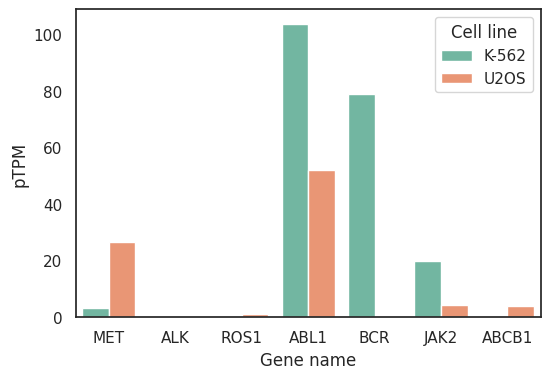

In [8]:
reload(tpp)
tpp.compareTargetRNAexpression_cellLines(expression_df, 
                                         targets = targets_to_compare, 
                                         cell_cp = 'U2OS', 
                                         cell_tpp = 'K-562',
                                         figsize=(6,4),
                                         file_name = '/share/data/analyses/camilla/cp_tpp/figures/figures_from_template/barchart_targetRNAexpression_cellline_crizotinib.svg'
                                        )